In [1]:
import pandas as pd
import numpy as np
import time
import h5py
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Flatten, GRU,TimeDistributed, Conv1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1
import ast
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from scipy.stats import uniform, truncnorm, randint
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from scipy.stats import loguniform
# from pandas import read_csv
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from datetime import datetime
from qkeras import *
today = datetime.date(datetime.now())
# from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model
from qkeras.utils import model_quantize
from qkeras.utils import model_save_quantized_weights

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#outdir = "/global/homes/e/elham/rnn_hls4ml/results/"
outpath = "gru_training_2022-08-09"
#comd = "mkdir "+outpath
#os.system(comd)

In [4]:
# inputdir = 'rnn_hls4ml_data_scaled'
inputdir = 'rnn_hls4ml_data_scaled_2class'

y-shape:  (379052, 1)
x-shape:  (379052, 20, 6)


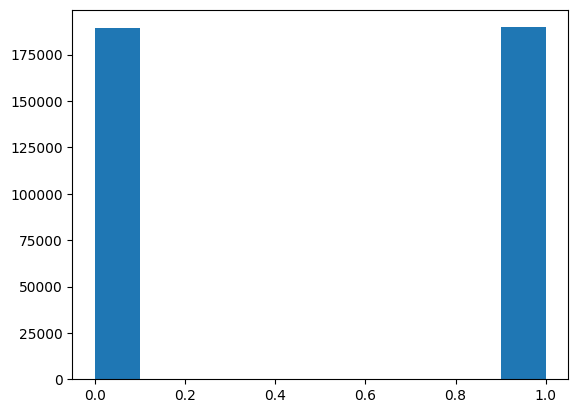

In [4]:
x_train = np.load('./x_train.npy')
y_train = np.load('./y_train.npy')

y_train = y_train[:,4:5]
plt.hist(y_train)

print("y-shape: ", y_train.shape)
print("x-shape: ", x_train.shape)

In [4]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                   random_state=104, 
                                   test_size=0.2, 
                                   shuffle=True)

In [8]:
x_train.shape

(303241, 20, 6)

In [3]:
x_train.shape

NameError: name 'x_train' is not defined

In [5]:
x_test = np.load('./x_test.npy')
y_test = np.load('./y_test.npy')

## Small GRU

In [6]:
model = Sequential()
model.add(GRU(5, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 0.00001, l2 = 0.0001),
              name = 'layer1', input_shape = (20,6)))
model.add(Dense(5, activation='relu', kernel_initializer='glorot_normal', name='layer2'))
model.add(Dense(1, activation='sigmoid', name = 'output_sigmoid'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (GRU)                (None, 5)                 195       
                                                                 
 layer2 (Dense)              (None, 5)                 30        
                                                                 
 output_sigmoid (Dense)      (None, 1)                 6         
                                                                 
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_loss',min_delta = 1e-4, mode='min', verbose=1, patience=20)
adam = Adam(lr = 0.0002)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = qmodel.fit(x_train.astype('float32'), y_train.astype('float32'), 
                    batch_size = 2**14,
                    epochs = 150, 
                    validation_split = 0.2, 
                    shuffle = True,
                    callbacks = [ModelCheckpoint(f'qgru_training/toptag_model_qgru.h5', verbose=1, save_best_only=True), es],
                    use_multiprocessing=True, workers=4)

## Small QGRU

In [8]:
qmodel = Sequential()
qmodel.add(QGRU(5, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 0.00001, l2 = 0.0001),
                name = 'layer1', kernel_quantizer=quantized_bits(2,0,alpha=1),
                recurrent_quantizer=quantized_bits(2,0,alpha=1) , bias_quantizer=quantized_bits(2,0,alpha=1),
                state_quantizer=quantized_bits(2,0,alpha=1) ,input_shape = (20,6)))
qmodel.add(QDense(5, activation='relu', kernel_initializer='glorot_normal', kernel_quantizer=quantized_bits(2,0,alpha=1),
                  bias_quantizer=quantized_bits(2,0,alpha=1), name='layer2'))
qmodel.add(QDense(1, activation='sigmoid', kernel_quantizer=quantized_bits(2,0,alpha=1),
                  bias_quantizer=quantized_bits(2,0,alpha=1), name = 'output_sigmoid'))
qmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (QGRU)               (None, 5)                 180       
                                                                 
 layer2 (QDense)             (None, 5)                 30        
                                                                 
 output_sigmoid (QDense)     (None, 1)                 6         
                                                                 
Total params: 216
Trainable params: 216
Non-trainable params: 0
_________________________________________________________________


In [9]:
es = EarlyStopping(monitor='val_loss',min_delta = 1e-4, mode='min', verbose=1, patience=20)
adam = Adam(lr = 0.0002)
qmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = qmodel.fit(x_train.astype('float32'), y_train.astype('float32'), 
                    batch_size = 2**14,
                    epochs = 150, 
                    validation_split = 0.2, 
                    shuffle = True,
                    callbacks = [ModelCheckpoint(f'qgru_training/toptag_model_qgru.h5', verbose=1, save_best_only=True), es],
                    use_multiprocessing=True, workers=4)

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/150
19/19 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.5100
Epoch 1: val_loss improved from inf to 0.69388, saving model to qgru_training\toptag_model_qgru.h5
19/19 [==============================] - 9s 152ms/step - loss: 0.6941 - accuracy: 0.5100 - val_loss: 0.6939 - val_accuracy: 0.5107
Epoch 2/150
 8/19 [===========>..................] - ETA: 1s - loss: 0.6941 - accuracy: 0.5091

KeyboardInterrupt: 

## GRU

In [31]:
model = Sequential()
model.add(GRU(20, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 0.00001, l2 = 0.0001), name = 'layer1', input_shape = (20,6)))
model.add(Dense(64,  kernel_initializer='glorot_normal', name='layer2')) #kernel_regularizer = regularizers.l1_l2(l1= 0.0001, l2 = 0.0001),
model.add(Activation('relu', name = 'relu_0'))
model.add(Dense(1, name = 'layer4'))
model.add(Activation('sigmoid', name = 'output_sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (GRU)                (None, 20)                1680      
                                                                 
 layer2 (Dense)              (None, 64)                1344      
                                                                 
 relu_0 (Activation)         (None, 64)                0         
                                                                 
 layer4 (Dense)              (None, 1)                 65        
                                                                 
 output_sigmoid (Activation)  (None, 1)                0         
                                                                 
Total params: 3,089
Trainable params: 3,089
Non-trainable params: 0
_________________________________________________________________


## GRU Training

In [10]:
es = EarlyStopping(monitor='val_loss',min_delta = 1e-4, mode='min', verbose=1, patience=20)
adam = Adam(lr = 0.0002)
    
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train.astype('float32'), y_train.astype('float32'), 
                    batch_size = 2**10,
                    epochs = 150, 
                    validation_data=(x_val.astype('float32'), y_val.astype('float32')), 
                    shuffle = True,
                    callbacks = [ModelCheckpoint(f'gru/model_gru.h5', verbose=1, save_best_only=True), es],
                    use_multiprocessing=True, workers=4)
        
labels = ['j_t']
y_keras = model.predict(x_test)
auc_score = roc_auc_score(y_test, y_keras)
print(auc_score)

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/150
294/297 [============================>.] - ETA: 0s - loss: 0.5334 - accuracy: 0.7424
Epoch 1: val_loss improved from inf to 0.41867, saving model to gru\model_gru.h5
297/297 [==============================] - 10s 8ms/step - loss: 0.5326 - accuracy: 0.7430 - val_loss: 0.4187 - val_accuracy: 0.8244
Epoch 2/150
291/297 [============================>.] - ETA: 0s - loss: 0.4027 - accuracy: 0.8331
Epoch 2: val_loss improved from 0.41867 to 0.38867, saving model to gru\model_gru.h5
297/297 [==============================] - 2s 5ms/step - loss: 0.4024 - accuracy: 0.8332 - val_loss: 0.3887 - val_accuracy: 0.8405
Epoch 3/150
297/297 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.8398
Epoch 3: val_loss improved from 0.38867 to 0.38510, saving model to gru\model_gru.h5
297/297 [==============================] - 2s 6ms/step - loss: 0.3899 - accuracy: 0.8398 - val_loss: 0.3851 - val_accuracy: 0.8419
Epoch 4/150
290/297 [============================>.] - ETA: 0s -

Epoch 57/150
290/297 [============================>.] - ETA: 0s - loss: 0.3465 - accuracy: 0.8559
Epoch 57: val_loss did not improve from 0.34158
297/297 [==============================] - 2s 6ms/step - loss: 0.3465 - accuracy: 0.8560 - val_loss: 0.3425 - val_accuracy: 0.8584
Epoch 58/150
288/297 [============================>.] - ETA: 0s - loss: 0.3472 - accuracy: 0.8554
Epoch 58: val_loss did not improve from 0.34158
297/297 [==============================] - 2s 5ms/step - loss: 0.3474 - accuracy: 0.8553 - val_loss: 0.3449 - val_accuracy: 0.8587
Epoch 59/150
290/297 [============================>.] - ETA: 0s - loss: 0.3456 - accuracy: 0.8561
Epoch 59: val_loss did not improve from 0.34158
297/297 [==============================] - 2s 6ms/step - loss: 0.3456 - accuracy: 0.8561 - val_loss: 0.3424 - val_accuracy: 0.8585
Epoch 60/150
295/297 [============================>.] - ETA: 0s - loss: 0.3460 - accuracy: 0.8560
Epoch 60: val_loss did not improve from 0.34158
297/297 [==============

291/297 [============================>.] - ETA: 0s - loss: 0.3378 - accuracy: 0.8596
Epoch 115: val_loss did not improve from 0.33409
297/297 [==============================] - 2s 6ms/step - loss: 0.3377 - accuracy: 0.8597 - val_loss: 0.3430 - val_accuracy: 0.8580
Epoch 116/150
297/297 [==============================] - ETA: 0s - loss: 0.3381 - accuracy: 0.8592
Epoch 116: val_loss did not improve from 0.33409
297/297 [==============================] - 2s 6ms/step - loss: 0.3381 - accuracy: 0.8592 - val_loss: 0.3427 - val_accuracy: 0.8565
Epoch 117/150
291/297 [============================>.] - ETA: 0s - loss: 0.3376 - accuracy: 0.8594
Epoch 117: val_loss did not improve from 0.33409
297/297 [==============================] - 2s 6ms/step - loss: 0.3375 - accuracy: 0.8594 - val_loss: 0.3359 - val_accuracy: 0.8616
Epoch 117: early stopping
624/624 [==============================] - 1s 2ms/step
0.9300515151321467


## Check GRU Weight

In [71]:
gru = load_model('gru/model_gru.h5')
for layer in gru.layers:
    weights = layer.get_weights()
    print(layer.name, weights)

layer1 [array([[ 3.85863095e-04, -4.31572989e-05, -8.73781159e-04,
        -1.92459358e-03,  1.29464571e-03, -7.83140678e-03,
        -4.52704169e-03, -3.65656661e-03, -3.18534370e-03,
         3.37608485e-03,  3.79501667e-04,  1.43090059e-04,
        -2.91849719e-04,  8.80206935e-04,  1.11935418e-02,
        -8.25973451e-02,  9.25967994e-04,  3.15461159e-02,
         1.89862424e-03, -9.26391571e-04,  1.34568941e-03,
        -3.21646483e-04, -3.17244732e-04,  9.94211645e-04,
        -1.33366417e-03, -9.53792632e-02,  5.20681147e-04,
        -6.92073663e-04, -5.64584276e-04,  2.83501897e-04,
        -1.50891044e-03, -8.75553465e-04,  1.81423943e-03,
        -1.65851277e-04,  1.15897600e-03,  1.42314332e-03,
        -2.79614981e-03,  3.73507763e-04, -2.02249549e-03,
        -1.82630494e-04, -3.94495055e-02,  8.40177685e-02,
        -7.14575201e-02,  4.64393914e-01, -6.57469153e-01,
        -6.35456562e-01,  4.78052169e-01, -2.35041808e-02,
         2.84459330e-02,  3.76566380e-01,  6.809

## LSTM

In [8]:
model = Sequential()
model.add(LSTM(20, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 0.00001, l2 = 0.0001),
               name = 'layer1', input_shape = (20,6)))
model.add(Dense(64, kernel_initializer='glorot_normal', name='layer3'))
model.add(Activation('relu', name = 'relu_0'))
model.add(Dense(1, name = 'layer5'))
model.add(Activation('sigmoid', name = 'output_sigmoid'))
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (LSTM)               (None, 20)                2160      
                                                                 
 layer3 (Dense)              (None, 64)                1344      
                                                                 
 relu_0 (Activation)         (None, 64)                0         
                                                                 
 layer5 (Dense)              (None, 1)                 65        
                                                                 
 output_sigmoid (Activation)  (None, 1)                0         
                                                                 
Total params: 3,569
Trainable params: 3,569
Non-trainable params: 0
_________________________________________________________________


In [9]:
es = EarlyStopping(monitor='val_loss',min_delta = 1e-4, mode='min', verbose=1, patience=150)
adam = Adam(lr = 0.0002)
    
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train.astype('float32'), y_train.astype('float32'), 
                    batch_size = 2**10,
                    epochs = 150, 
                    validation_data=(x_val.astype('float32'), y_val.astype('float32')), 
                    shuffle = True,
                    callbacks = [ModelCheckpoint(f'lstm/model_lstm.h5', verbose=1, save_best_only=True), es],
                    use_multiprocessing=True, workers=4)
labels = ['j_t']
y_keras = model.predict(x_test)
auc_score = roc_auc_score(y_test, y_keras)
print(auc_score)

# print(history.history.keys())
#     # summarize history for accuracy
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# print(history.history.keys())
#     # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

Epoch 1/150
287/297 [===========================>..] - ETA: 0s - loss: 0.4787 - accuracy: 0.7738
Epoch 1: val_loss improved from inf to 0.39776, saving model to lstm\model_lstm.h5
297/297 [==============================] - 4s 8ms/step - loss: 0.4765 - accuracy: 0.7755 - val_loss: 0.3978 - val_accuracy: 0.8369
Epoch 2/150
293/297 [============================>.] - ETA: 0s - loss: 0.3953 - accuracy: 0.8376
Epoch 2: val_loss improved from 0.39776 to 0.38684, saving model to lstm\model_lstm.h5
297/297 [==============================] - 2s 6ms/step - loss: 0.3952 - accuracy: 0.8376 - val_loss: 0.3868 - val_accuracy: 0.8419
Epoch 3/150
287/297 [===========================>..] - ETA: 0s - loss: 0.3879 - accuracy: 0.8411
Epoch 3: val_loss improved from 0.38684 to 0.38110, saving model to lstm\model_lstm.h5
297/297 [==============================] - 2s 6ms/step - loss: 0.3880 - accuracy: 0.8410 - val_loss: 0.3811 - val_accuracy: 0.8449
Epoch 4/150
290/297 [============================>.] - ETA:

297/297 [==============================] - 2s 6ms/step - loss: 0.3500 - accuracy: 0.8550 - val_loss: 0.3443 - val_accuracy: 0.8579
Epoch 29/150
296/297 [============================>.] - ETA: 0s - loss: 0.3494 - accuracy: 0.8555
Epoch 29: val_loss improved from 0.34432 to 0.34419, saving model to lstm\model_lstm.h5
297/297 [==============================] - 2s 6ms/step - loss: 0.3493 - accuracy: 0.8555 - val_loss: 0.3442 - val_accuracy: 0.8585
Epoch 30/150
287/297 [===========================>..] - ETA: 0s - loss: 0.3506 - accuracy: 0.8549
Epoch 30: val_loss did not improve from 0.34419
297/297 [==============================] - 2s 6ms/step - loss: 0.3507 - accuracy: 0.8549 - val_loss: 0.3468 - val_accuracy: 0.8581
Epoch 31/150
293/297 [============================>.] - ETA: 0s - loss: 0.3502 - accuracy: 0.8552
Epoch 31: val_loss did not improve from 0.34419
297/297 [==============================] - 2s 6ms/step - loss: 0.3502 - accuracy: 0.8552 - val_loss: 0.3485 - val_accuracy: 0.855

297/297 [==============================] - 2s 6ms/step - loss: 0.3449 - accuracy: 0.8565 - val_loss: 0.3514 - val_accuracy: 0.8524
Epoch 58/150
297/297 [==============================] - ETA: 0s - loss: 0.3443 - accuracy: 0.8570
Epoch 58: val_loss improved from 0.34025 to 0.33843, saving model to lstm\model_lstm.h5
297/297 [==============================] - 2s 6ms/step - loss: 0.3443 - accuracy: 0.8570 - val_loss: 0.3384 - val_accuracy: 0.8605
Epoch 59/150
296/297 [============================>.] - ETA: 0s - loss: 0.3431 - accuracy: 0.8575
Epoch 59: val_loss did not improve from 0.33843
297/297 [==============================] - 2s 6ms/step - loss: 0.3431 - accuracy: 0.8575 - val_loss: 0.3392 - val_accuracy: 0.8603
Epoch 60/150
288/297 [============================>.] - ETA: 0s - loss: 0.3446 - accuracy: 0.8565
Epoch 60: val_loss did not improve from 0.33843
297/297 [==============================] - 2s 6ms/step - loss: 0.3446 - accuracy: 0.8565 - val_loss: 0.3520 - val_accuracy: 0.852

297/297 [==============================] - 2s 6ms/step - loss: 0.3409 - accuracy: 0.8581 - val_loss: 0.3366 - val_accuracy: 0.8605
Epoch 87/150
287/297 [===========================>..] - ETA: 0s - loss: 0.3408 - accuracy: 0.8581
Epoch 87: val_loss did not improve from 0.33641
297/297 [==============================] - 2s 6ms/step - loss: 0.3407 - accuracy: 0.8582 - val_loss: 0.3369 - val_accuracy: 0.8609
Epoch 88/150
297/297 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.8580
Epoch 88: val_loss did not improve from 0.33641
297/297 [==============================] - 2s 6ms/step - loss: 0.3408 - accuracy: 0.8580 - val_loss: 0.3368 - val_accuracy: 0.8611
Epoch 89/150
291/297 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8577
Epoch 89: val_loss did not improve from 0.33641
297/297 [==============================] - 2s 6ms/step - loss: 0.3412 - accuracy: 0.8577 - val_loss: 0.3370 - val_accuracy: 0.8615
Epoch 90/150
294/297 [================

297/297 [==============================] - 2s 6ms/step - loss: 0.3403 - accuracy: 0.8582 - val_loss: 0.3354 - val_accuracy: 0.8611
Epoch 116/150
293/297 [============================>.] - ETA: 0s - loss: 0.3384 - accuracy: 0.8591
Epoch 116: val_loss did not improve from 0.33373
297/297 [==============================] - 2s 6ms/step - loss: 0.3383 - accuracy: 0.8591 - val_loss: 0.3372 - val_accuracy: 0.8607
Epoch 117/150
295/297 [============================>.] - ETA: 0s - loss: 0.3391 - accuracy: 0.8583
Epoch 117: val_loss did not improve from 0.33373
297/297 [==============================] - 2s 6ms/step - loss: 0.3390 - accuracy: 0.8583 - val_loss: 0.3361 - val_accuracy: 0.8602
Epoch 118/150
295/297 [============================>.] - ETA: 0s - loss: 0.3382 - accuracy: 0.8589
Epoch 118: val_loss did not improve from 0.33373
297/297 [==============================] - 2s 5ms/step - loss: 0.3382 - accuracy: 0.8589 - val_loss: 0.3364 - val_accuracy: 0.8602
Epoch 119/150
295/297 [=========

## LSTM weight

In [73]:
lstm = load_model('lstm/model_toptag_lstm.h5')
for layer in lstm.layers:
    weights = layer.get_weights()
    print(layer.name, weights)

layer1 [array([[ 7.39419879e-03, -5.83838159e-03,  3.01538318e-01,
         1.71923459e-01,  6.68122293e-03,  2.97626834e-02,
         3.32187265e-01,  1.97732152e-04, -2.47867294e-02,
        -2.70899326e-01,  2.38649055e-01, -1.53928593e-01,
        -2.45593235e-01, -4.70351195e-03, -4.40326781e-04,
        -9.93248895e-02, -4.17812057e-02,  1.16892830e-02,
         3.17993254e-05, -1.51097625e-01,  1.57310724e-01,
         3.35737281e-02,  1.41706407e-01, -2.90701236e-03,
        -1.97995920e-03, -2.25614622e-01, -1.60605669e-01,
         4.88352962e-04, -7.87862241e-02,  1.11477904e-01,
        -2.62344658e-01, -4.76501277e-03, -1.96079127e-02,
        -1.55211061e-01,  4.44040663e-04, -2.17573345e-02,
        -1.32157400e-01,  3.02360058e-02,  1.89535355e-03,
         1.29000042e-02,  1.78925186e-01,  1.04064144e-01,
         4.50133756e-02,  3.35197598e-01,  7.82899320e-01,
        -6.99297264e-02, -2.05348253e-01,  4.42941576e-01,
         5.70073307e-01,  1.53039768e-01, -3.163

## Quantization Aware Training

## QGRU

In [33]:
# new_GRU_0int = []
# new_GRU_2int = []
# new_GRU_4int = []
for j in [0]:
    for i in [10]:
        print(i)
        int_bits = j
        total_bits = i + int_bits + 1
        config = {
            "QGRU":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits}, {int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QDense":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "relu_0" : f"quantized_relu({total_bits},{int_bits},1)"
        }
    
        qmodel = model_quantize(model, config, total_bits, transfer_weights=True)
        qmodel.summary()
        
#         es = EarlyStopping(monitor='val_loss',min_delta = 1e-4, mode='min', verbose=1, patience=20)
        adam = Adam(lr = 0.0002)
    
        qmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        history = qmodel.fit(x_train.astype('float32'), y_train.astype('float32'), 
                    batch_size = 2**14,
                    epochs = 100, 
                    validation_data=(x_val.astype('float32'), y_val.astype('float32')), 
                    shuffle = True,
#                     callbacks = [ModelCheckpoint(f'qgru_{j}int_test3/model_qgru_{i}frac.h5', verbose=1, save_best_only=True), es],
                    callbacks = [ModelCheckpoint(f'qgru_{j}int_test5/model_qgru_{i}frac.h5', verbose=1, save_best_only=True)],
                    use_multiprocessing=True, workers=4)
        
        labels = ['j_t']
        y_keras = qmodel.predict(x_test)
        auc_score = roc_auc_score(y_test, y_keras)
        print(auc_score)
#         if j == 2:
#             new_GRU_2int.append(auc_score)
#         elif j == 4:
#             new_GRU_4int.append(auc_score)
#         else:
#             new_GRU_0int.append(auc_score)

10
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (QGRU)               (None, 20)                1680      
                                                                 
 layer2 (QDense)             (None, 64)                1344      
                                                                 
 relu_0 (QActivation)        (None, 64)                0         
                                                                 
 layer4 (QDense)             (None, 1)                 65        
                                                                 
 output_sigmoid (Activation)  (None, 1)                0         
                                                                 
Total params: 3,089
Trainable params: 3,089
Non-trainable params: 0
_________________________________________________________________


C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.7064 - accuracy: 0.5002
Epoch 1: val_loss improved from inf to 0.70072, saving model to qgru_0int_test5\model_qgru_10frac.h5
19/19 [==============================] - 9s 219ms/step - loss: 0.7064 - accuracy: 0.5002 - val_loss: 0.7007 - val_accuracy: 0.4993
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6991 - accuracy: 0.5182
Epoch 2: val_loss improved from 0.70072 to 0.69728, saving model to qgru_0int_test5\model_qgru_10frac.h5
19/19 [==============================] - 3s 148ms/step - loss: 0.6991 - accuracy: 0.5182 - val_loss: 0.6973 - val_accuracy: 0.5151
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6959 - accuracy: 0.5848
Epoch 3: val_loss improved from 0.69728 to 0.69423, saving model to qgru_0int_test5\model_qgru_10frac.h5
19/19 [==============================] - 3s 163ms/step - loss: 0.6959 - accuracy: 0.5848 - val_loss: 0.6942 - val_accuracy: 0.6313
Epoch 4/100

Epoch 26/100
19/19 [==============================] - ETA: 0s - loss: 0.3925 - accuracy: 0.8374
Epoch 26: val_loss did not improve from 0.39104
19/19 [==============================] - 3s 145ms/step - loss: 0.3925 - accuracy: 0.8374 - val_loss: 0.3912 - val_accuracy: 0.8386
Epoch 27/100
19/19 [==============================] - ETA: 0s - loss: 0.3938 - accuracy: 0.8365
Epoch 27: val_loss did not improve from 0.39104
19/19 [==============================] - 3s 145ms/step - loss: 0.3938 - accuracy: 0.8365 - val_loss: 0.3954 - val_accuracy: 0.8363
Epoch 28/100
19/19 [==============================] - ETA: 0s - loss: 0.3933 - accuracy: 0.8369
Epoch 28: val_loss improved from 0.39104 to 0.39005, saving model to qgru_0int_test5\model_qgru_10frac.h5
19/19 [==============================] - 3s 174ms/step - loss: 0.3933 - accuracy: 0.8369 - val_loss: 0.3900 - val_accuracy: 0.8389
Epoch 29/100
19/19 [==============================] - ETA: 0s - loss: 0.3906 - accuracy: 0.8386
Epoch 29: val_loss im

19/19 [==============================] - ETA: 0s - loss: 0.3786 - accuracy: 0.8435
Epoch 80: val_loss did not improve from 0.37541
19/19 [==============================] - 3s 159ms/step - loss: 0.3786 - accuracy: 0.8435 - val_loss: 0.3758 - val_accuracy: 0.8444
Epoch 81/100
19/19 [==============================] - ETA: 0s - loss: 0.3789 - accuracy: 0.8435
Epoch 81: val_loss did not improve from 0.37541
19/19 [==============================] - 3s 158ms/step - loss: 0.3789 - accuracy: 0.8435 - val_loss: 0.3756 - val_accuracy: 0.8449
Epoch 82/100
19/19 [==============================] - ETA: 0s - loss: 0.3838 - accuracy: 0.8409
Epoch 82: val_loss did not improve from 0.37541
19/19 [==============================] - 3s 156ms/step - loss: 0.3838 - accuracy: 0.8409 - val_loss: 0.3851 - val_accuracy: 0.8406
Epoch 83/100
19/19 [==============================] - ETA: 0s - loss: 0.3798 - accuracy: 0.8426
Epoch 83: val_loss did not improve from 0.37541
19/19 [==============================] - 3s 

In [21]:
new_GRU_0int = [0.5,
 0.869639715261932,
 0.899766569639262,
 0.9077515075788266,
 0.907255361159058,
 0.9086699756561188,
 0.9084545160876278,
 0.90879608877093,
 0.911936244026837,
 0.9159078273020733]

In [22]:
new_GRU_2int = [0.678278580202494, 0.8750350682695142, 0.9189444158431276, 0.9280197513498394, 0.9304802987175395, 0.930746468842835, 0.931037592260351, 0.9304744045951524, 0.9309199510043162, 0.9312094916012423]

In [23]:
new_GRU_4int = [0.6830493672797799, 0.8932695031535212, 0.9190298328818828, 0.9289021059935456, 0.9304643197668222, 0.9293353214765903, 0.9310884485371462, 0.9311022366631738, 0.931189929948682, 0.9312454794141469]

(0.5, 0.95)

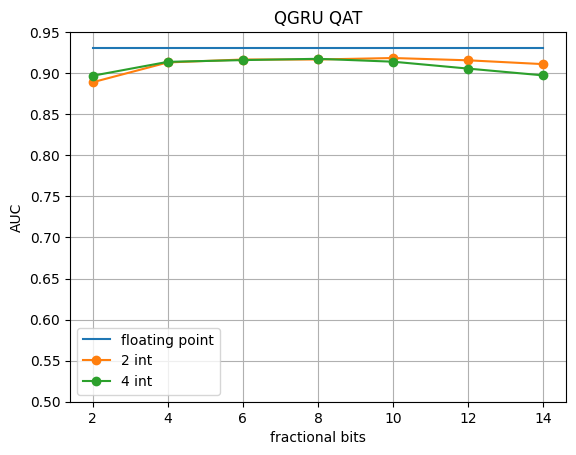

In [8]:
float_gru = [0.9307736230093996, 0.9307736230093996, 0.9307736230093996, 0.9307736230093996, 0.9307736230093996, 0.9307736230093996, 0.9307736230093996]
plt.plot([2,4,6,8,10,12,14], float_gru, "-", label = "floating point")
plt.plot([2,4,6,8,10,12,14], GRU_2int, "-o", label = '2 int')
plt.plot([2,4,6,8,10,12,14], GRU_4int, "-o", label = '4 int')

plt.legend()
plt.xlabel("fractional bits")
plt.ylabel("AUC")
plt.title("QGRU QAT")
plt.grid()
plt.ylim([0.5, 0.95]) 

## QGRU weight

In [22]:
# qgru = load_model('qgru_2int_test3/model_qgru_2frac.h5', custom_objects={'QGRU': QGRU, 'QDense': QDense, 'quantized_bits': quantized_bits, 'QActivation': QActivation})
model_save_quantized_weights(qmodel, f"gru2int2fra_weight")

... quantizing model


{'layer1': {'weights': [array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

## QLSTM

In [20]:
new_LSTM_0int = []
new_LSTM_2int = []
new_LSTM_4int = []
for j in [0, 2, 4]:
    for i in [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]:
        int_bits = j
        total_bits = i + int_bits + 1
        config = {
            "QLSTM":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits}, {int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QDense":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
#             "relu_1" : f"quantized_relu({total_bits},{int_bits},1)",
        }
    
        qmodel = model_quantize(model, config, total_bits, transfer_weights=True)
        qmodel.summary()
        
#         es = EarlyStopping(monitor='val_loss',min_delta = 1e-4, mode='min', verbose=1, patience=20)
        adam = Adam(lr = 0.0002)
    
        qmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        history = qmodel.fit(x_train.astype('float32'), y_train.astype('float32'), 
                    batch_size = 2**14,
                    epochs = 100, 
                    validation_data=(x_val.astype('float32'), y_val.astype('float32')), 
                    shuffle = True,
#                     callbacks = [ModelCheckpoint(f'qlstm_{j}int_test5/model_qlstm_{i}frac.h5', verbose=1, save_best_only=True), es],
                    callbacks = [ModelCheckpoint(f'qlstm_{j}int_test5/model_qlstm_{i}frac.h5', verbose=1, save_best_only=True)],
                    use_multiprocessing=True, workers=4)
        
        labels = ['j_t']
        y_keras = qmodel.predict(x_test)
        auc_score = roc_auc_score(y_test, y_keras)
        print(auc_score)
        if j == 2:
            new_LSTM_2int.append(auc_score)
        elif j == 4:
            new_LSTM_4int.append(auc_score)
        else:
            new_LSTM_0int.append(auc_score)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (QLSTM)              (None, 20)                2160      
                                                                 
 layer3 (QDense)             (None, 64)                1344      
                                                                 
 relu_0 (QActivation)        (None, 64)                0         
                                                                 
 layer5 (QDense)             (None, 1)                 65        
                                                                 
 output_sigmoid (Activation)  (None, 1)                0         
                                                                 
Total params: 3,569
Trainable params: 3,569
Non-trainable params: 0
_________________________________________________________________


C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.8234 - accuracy: 0.5001
Epoch 1: val_loss improved from inf to 0.82405, saving model to qlstm_0int_test5\model_qlstm_0frac.h5
19/19 [==============================] - 9s 245ms/step - loss: 0.8234 - accuracy: 0.5001 - val_loss: 0.8241 - val_accuracy: 0.4991
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.8229 - accuracy: 0.4999
Epoch 2: val_loss improved from 0.82405 to 0.82151, saving model to qlstm_0int_test5\model_qlstm_0frac.h5
19/19 [==============================] - 3s 163ms/step - loss: 0.8229 - accuracy: 0.4999 - val_loss: 0.8215 - val_accuracy: 0.5009
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.8229 - accuracy: 0.4993
Epoch 3: val_loss did not improve from 0.82151
19/19 [==============================] - 3s 164ms/step - loss: 0.8229 - accuracy: 0.4993 - val_loss: 0.8227 - val_accuracy: 0.4991
Epoch 4/100
19/19 [==============================] - ETA: 0s - loss

19/19 [==============================] - ETA: 0s - loss: 0.8121 - accuracy: 0.5013
Epoch 53: val_loss did not improve from 0.81249
19/19 [==============================] - 3s 159ms/step - loss: 0.8121 - accuracy: 0.5013 - val_loss: 0.8143 - val_accuracy: 0.4991
Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.8131 - accuracy: 0.5003
Epoch 54: val_loss did not improve from 0.81249
19/19 [==============================] - 3s 174ms/step - loss: 0.8131 - accuracy: 0.5003 - val_loss: 0.8143 - val_accuracy: 0.4991
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.8134 - accuracy: 0.5000
Epoch 55: val_loss did not improve from 0.81249
19/19 [==============================] - 3s 162ms/step - loss: 0.8134 - accuracy: 0.5000 - val_loss: 0.8143 - val_accuracy: 0.4991
Epoch 56/100
19/19 [==============================] - ETA: 0s - loss: 0.8135 - accuracy: 0.4998
Epoch 56: val_loss did not improve from 0.81249
19/19 [==============================] - 3s 

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7073 - accuracy: 0.4943
Epoch 1: val_loss improved from inf to 0.70401, saving model to qlstm_0int_test5\model_qlstm_2frac.h5
19/19 [==============================] - 10s 245ms/step - loss: 0.7073 - accuracy: 0.4943 - val_loss: 0.7040 - val_accuracy: 0.4926
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.7018 - accuracy: 0.5148
Epoch 2: val_loss improved from 0.70401 to 0.69837, saving model to qlstm_0int_test5\model_qlstm_2frac.h5
19/19 [==============================] - 3s 180ms/step - loss: 0.7018 - accuracy: 0.5148 - val_loss: 0.6984 - val_accuracy: 0.5373
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6914 - accuracy: 0.5735
Epoch 3: val_loss improved from 0.69837 to 0.68868, saving model to qlstm_0int_test5\model_qlstm_2frac.h5
19/19 [==============================] - 3s 169ms/step - loss: 0.6914 - accuracy: 0.5735 - val_loss: 0.6887 - val_accuracy: 0.5691
Epoch 4/100
19/19 [

19/19 [==============================] - 3s 170ms/step - loss: 0.5361 - accuracy: 0.7475 - val_loss: 0.5376 - val_accuracy: 0.7451
Epoch 28/100
19/19 [==============================] - ETA: 0s - loss: 0.5401 - accuracy: 0.7468
Epoch 28: val_loss improved from 0.53760 to 0.53169, saving model to qlstm_0int_test5\model_qlstm_2frac.h5
19/19 [==============================] - 4s 193ms/step - loss: 0.5401 - accuracy: 0.7468 - val_loss: 0.5317 - val_accuracy: 0.7530
Epoch 29/100
19/19 [==============================] - ETA: 0s - loss: 0.5484 - accuracy: 0.7360
Epoch 29: val_loss did not improve from 0.53169
19/19 [==============================] - 3s 177ms/step - loss: 0.5484 - accuracy: 0.7360 - val_loss: 0.5469 - val_accuracy: 0.7369
Epoch 30/100
19/19 [==============================] - ETA: 0s - loss: 0.5492 - accuracy: 0.7344
Epoch 30: val_loss did not improve from 0.53169
19/19 [==============================] - 3s 167ms/step - loss: 0.5492 - accuracy: 0.7344 - val_loss: 0.5367 - val_ac

19/19 [==============================] - ETA: 0s - loss: 0.5452 - accuracy: 0.7461
Epoch 56: val_loss did not improve from 0.51321
19/19 [==============================] - 3s 172ms/step - loss: 0.5452 - accuracy: 0.7461 - val_loss: 0.5307 - val_accuracy: 0.7552
Epoch 57/100
19/19 [==============================] - ETA: 0s - loss: 0.5368 - accuracy: 0.7526
Epoch 57: val_loss improved from 0.51321 to 0.51020, saving model to qlstm_0int_test5\model_qlstm_2frac.h5
19/19 [==============================] - 3s 186ms/step - loss: 0.5368 - accuracy: 0.7526 - val_loss: 0.5102 - val_accuracy: 0.7773
Epoch 58/100
19/19 [==============================] - ETA: 0s - loss: 0.5734 - accuracy: 0.7282
Epoch 58: val_loss did not improve from 0.51020
19/19 [==============================] - 3s 170ms/step - loss: 0.5734 - accuracy: 0.7282 - val_loss: 0.5398 - val_accuracy: 0.7425
Epoch 59/100
19/19 [==============================] - ETA: 0s - loss: 0.5338 - accuracy: 0.7535
Epoch 59: val_loss did not improv

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.5127
Epoch 1: val_loss improved from inf to 0.70201, saving model to qlstm_0int_test5\model_qlstm_4frac.h5
19/19 [==============================] - 10s 257ms/step - loss: 0.7059 - accuracy: 0.5127 - val_loss: 0.7020 - val_accuracy: 0.5072
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6981 - accuracy: 0.5669
Epoch 2: val_loss improved from 0.70201 to 0.69029, saving model to qlstm_0int_test5\model_qlstm_4frac.h5
19/19 [==============================] - 3s 169ms/step - loss: 0.6981 - accuracy: 0.5669 - val_loss: 0.6903 - val_accuracy: 0.6722
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6805 - accuracy: 0.6317
Epoch 3: val_loss improved from 0.69029 to 0.65059, saving model to qlstm_0int_test5\model_qlstm_4frac.h5
19/19 [==============================] - 3s 176ms/step - loss: 0.6805 - accuracy: 0.6317 - val_loss: 0.6506 - val_accuracy: 0.6159
Epoch 4/100
19/19 [

19/19 [==============================] - 3s 173ms/step - loss: 0.3971 - accuracy: 0.8365 - val_loss: 0.3948 - val_accuracy: 0.8383
Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.3971 - accuracy: 0.8366
Epoch 54: val_loss improved from 0.39477 to 0.39436, saving model to qlstm_0int_test5\model_qlstm_4frac.h5
19/19 [==============================] - 3s 175ms/step - loss: 0.3971 - accuracy: 0.8366 - val_loss: 0.3944 - val_accuracy: 0.8382
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.3969 - accuracy: 0.8362
Epoch 55: val_loss improved from 0.39436 to 0.39280, saving model to qlstm_0int_test5\model_qlstm_4frac.h5
19/19 [==============================] - 3s 165ms/step - loss: 0.3969 - accuracy: 0.8362 - val_loss: 0.3928 - val_accuracy: 0.8383
Epoch 56/100
19/19 [==============================] - ETA: 0s - loss: 0.3975 - accuracy: 0.8362
Epoch 56: val_loss did not improve from 0.39280
19/19 [==============================] - 3s 167ms/step - 

Epoch 82/100
19/19 [==============================] - ETA: 0s - loss: 0.4010 - accuracy: 0.8337
Epoch 82: val_loss improved from 0.38991 to 0.38856, saving model to qlstm_0int_test5\model_qlstm_4frac.h5
19/19 [==============================] - 3s 180ms/step - loss: 0.4010 - accuracy: 0.8337 - val_loss: 0.3886 - val_accuracy: 0.8408
Epoch 83/100
19/19 [==============================] - ETA: 0s - loss: 0.4033 - accuracy: 0.8323
Epoch 83: val_loss did not improve from 0.38856
19/19 [==============================] - 3s 164ms/step - loss: 0.4033 - accuracy: 0.8323 - val_loss: 0.3933 - val_accuracy: 0.8381
Epoch 84/100
19/19 [==============================] - ETA: 0s - loss: 0.3923 - accuracy: 0.8388
Epoch 84: val_loss did not improve from 0.38856
19/19 [==============================] - 3s 170ms/step - loss: 0.3923 - accuracy: 0.8388 - val_loss: 0.3900 - val_accuracy: 0.8402
Epoch 85/100
19/19 [==============================] - ETA: 0s - loss: 0.3910 - accuracy: 0.8392
Epoch 85: val_loss i

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7058 - accuracy: 0.5027
Epoch 1: val_loss improved from inf to 0.70161, saving model to qlstm_0int_test5\model_qlstm_6frac.h5
19/19 [==============================] - 9s 246ms/step - loss: 0.7058 - accuracy: 0.5027 - val_loss: 0.7016 - val_accuracy: 0.4991
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6969 - accuracy: 0.6023
Epoch 2: val_loss improved from 0.70161 to 0.68948, saving model to qlstm_0int_test5\model_qlstm_6frac.h5
19/19 [==============================] - 3s 172ms/step - loss: 0.6969 - accuracy: 0.6023 - val_loss: 0.6895 - val_accuracy: 0.6671
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6692 - accuracy: 0.6566
Epoch 3: val_loss improved from 0.68948 to 0.62231, saving model to qlstm_0int_test5\model_qlstm_6frac.h5
19/19 [==============================] - 3s 181ms/step - loss: 0.6692 - accuracy: 0.6566 - val_loss: 0.6223 - val_accuracy: 0.6990
Epoch 4/100
19/19 [=

19/19 [==============================] - 3s 165ms/step - loss: 0.4010 - accuracy: 0.8352 - val_loss: 0.3935 - val_accuracy: 0.8381
Epoch 27/100
19/19 [==============================] - ETA: 0s - loss: 0.4014 - accuracy: 0.8349
Epoch 27: val_loss did not improve from 0.38928
19/19 [==============================] - 3s 175ms/step - loss: 0.4014 - accuracy: 0.8349 - val_loss: 0.4030 - val_accuracy: 0.8334
Epoch 28/100
19/19 [==============================] - ETA: 0s - loss: 0.3998 - accuracy: 0.8360
Epoch 28: val_loss did not improve from 0.38928
19/19 [==============================] - 3s 170ms/step - loss: 0.3998 - accuracy: 0.8360 - val_loss: 0.4257 - val_accuracy: 0.8225
Epoch 29/100
19/19 [==============================] - ETA: 0s - loss: 0.3954 - accuracy: 0.8379
Epoch 29: val_loss did not improve from 0.38928
19/19 [==============================] - 3s 164ms/step - loss: 0.3954 - accuracy: 0.8379 - val_loss: 0.3983 - val_accuracy: 0.8368
Epoch 30/100
19/19 [========================

Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.3771 - accuracy: 0.8446
Epoch 54: val_loss did not improve from 0.36953
19/19 [==============================] - 3s 171ms/step - loss: 0.3771 - accuracy: 0.8446 - val_loss: 0.3738 - val_accuracy: 0.8452
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.3728 - accuracy: 0.8468
Epoch 55: val_loss improved from 0.36953 to 0.36888, saving model to qlstm_0int_test5\model_qlstm_6frac.h5
19/19 [==============================] - 3s 186ms/step - loss: 0.3728 - accuracy: 0.8468 - val_loss: 0.3689 - val_accuracy: 0.8494
Epoch 56/100
19/19 [==============================] - ETA: 0s - loss: 0.3717 - accuracy: 0.8472
Epoch 56: val_loss improved from 0.36888 to 0.36848, saving model to qlstm_0int_test5\model_qlstm_6frac.h5
19/19 [==============================] - 3s 168ms/step - loss: 0.3717 - accuracy: 0.8472 - val_loss: 0.3685 - val_accuracy: 0.8494
Epoch 57/100
19/19 [==============================] - ETA

Epoch 82/100
19/19 [==============================] - ETA: 0s - loss: 0.3668 - accuracy: 0.8493
Epoch 82: val_loss did not improve from 0.36158
19/19 [==============================] - 3s 176ms/step - loss: 0.3668 - accuracy: 0.8493 - val_loss: 0.3716 - val_accuracy: 0.8451
Epoch 83/100
19/19 [==============================] - ETA: 0s - loss: 0.3690 - accuracy: 0.8481
Epoch 83: val_loss did not improve from 0.36158
19/19 [==============================] - 3s 171ms/step - loss: 0.3690 - accuracy: 0.8481 - val_loss: 0.3753 - val_accuracy: 0.8450
Epoch 84/100
19/19 [==============================] - ETA: 0s - loss: 0.3731 - accuracy: 0.8453
Epoch 84: val_loss did not improve from 0.36158
19/19 [==============================] - 3s 177ms/step - loss: 0.3731 - accuracy: 0.8453 - val_loss: 0.3649 - val_accuracy: 0.8512
Epoch 85/100
19/19 [==============================] - ETA: 0s - loss: 0.3648 - accuracy: 0.8506
Epoch 85: val_loss improved from 0.36158 to 0.36121, saving model to qlstm_0int

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7056 - accuracy: 0.5044
Epoch 1: val_loss improved from inf to 0.70101, saving model to qlstm_0int_test5\model_qlstm_8frac.h5
19/19 [==============================] - 10s 256ms/step - loss: 0.7056 - accuracy: 0.5044 - val_loss: 0.7010 - val_accuracy: 0.4991
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.5977
Epoch 2: val_loss improved from 0.70101 to 0.68779, saving model to qlstm_0int_test5\model_qlstm_8frac.h5
19/19 [==============================] - 3s 182ms/step - loss: 0.6962 - accuracy: 0.5977 - val_loss: 0.6878 - val_accuracy: 0.6268
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6665 - accuracy: 0.6533
Epoch 3: val_loss improved from 0.68779 to 0.62100, saving model to qlstm_0int_test5\model_qlstm_8frac.h5
19/19 [==============================] - 3s 181ms/step - loss: 0.6665 - accuracy: 0.6533 - val_loss: 0.6210 - val_accuracy: 0.7017
Epoch 4/100
19/19 [

Epoch 53/100
19/19 [==============================] - ETA: 0s - loss: 0.3687 - accuracy: 0.8491
Epoch 53: val_loss improved from 0.36516 to 0.36456, saving model to qlstm_0int_test5\model_qlstm_8frac.h5
19/19 [==============================] - 3s 166ms/step - loss: 0.3687 - accuracy: 0.8491 - val_loss: 0.3646 - val_accuracy: 0.8522
Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.3669 - accuracy: 0.8501
Epoch 54: val_loss improved from 0.36456 to 0.36340, saving model to qlstm_0int_test5\model_qlstm_8frac.h5
19/19 [==============================] - 3s 176ms/step - loss: 0.3669 - accuracy: 0.8501 - val_loss: 0.3634 - val_accuracy: 0.8520
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.3669 - accuracy: 0.8501
Epoch 55: val_loss improved from 0.36340 to 0.36336, saving model to qlstm_0int_test5\model_qlstm_8frac.h5
19/19 [==============================] - 3s 169ms/step - loss: 0.3669 - accuracy: 0.8501 - val_loss: 0.3634 - val_accuracy: 0.852

Epoch 81/100
19/19 [==============================] - ETA: 0s - loss: 0.3622 - accuracy: 0.8517
Epoch 81: val_loss improved from 0.35925 to 0.35896, saving model to qlstm_0int_test5\model_qlstm_8frac.h5
19/19 [==============================] - 3s 164ms/step - loss: 0.3622 - accuracy: 0.8517 - val_loss: 0.3590 - val_accuracy: 0.8531
Epoch 82/100
19/19 [==============================] - ETA: 0s - loss: 0.4387 - accuracy: 0.8151
Epoch 82: val_loss did not improve from 0.35896
19/19 [==============================] - 3s 168ms/step - loss: 0.4387 - accuracy: 0.8151 - val_loss: 0.3861 - val_accuracy: 0.8453
Epoch 83/100
19/19 [==============================] - ETA: 0s - loss: 0.3801 - accuracy: 0.8451
Epoch 83: val_loss did not improve from 0.35896
19/19 [==============================] - 3s 176ms/step - loss: 0.3801 - accuracy: 0.8451 - val_loss: 0.3745 - val_accuracy: 0.8471
Epoch 84/100
19/19 [==============================] - ETA: 0s - loss: 0.3787 - accuracy: 0.8463
Epoch 84: val_loss d

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7056 - accuracy: 0.5037
Epoch 1: val_loss improved from inf to 0.70093, saving model to qlstm_0int_test5\model_qlstm_10frac.h5
19/19 [==============================] - 9s 244ms/step - loss: 0.7056 - accuracy: 0.5037 - val_loss: 0.7009 - val_accuracy: 0.4991
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6963 - accuracy: 0.5990
Epoch 2: val_loss improved from 0.70093 to 0.68830, saving model to qlstm_0int_test5\model_qlstm_10frac.h5
19/19 [==============================] - 3s 174ms/step - loss: 0.6963 - accuracy: 0.5990 - val_loss: 0.6883 - val_accuracy: 0.6105
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6654 - accuracy: 0.6530
Epoch 3: val_loss improved from 0.68830 to 0.61684, saving model to qlstm_0int_test5\model_qlstm_10frac.h5
19/19 [==============================] - 3s 167ms/step - loss: 0.6654 - accuracy: 0.6530 - val_loss: 0.6168 - val_accuracy: 0.7004
Epoch 4/100
19/19

Epoch 27/100
19/19 [==============================] - ETA: 0s - loss: 0.3824 - accuracy: 0.8442
Epoch 27: val_loss improved from 0.37864 to 0.37728, saving model to qlstm_0int_test5\model_qlstm_10frac.h5
19/19 [==============================] - 3s 177ms/step - loss: 0.3824 - accuracy: 0.8442 - val_loss: 0.3773 - val_accuracy: 0.8466
Epoch 28/100
19/19 [==============================] - ETA: 0s - loss: 0.3804 - accuracy: 0.8450
Epoch 28: val_loss improved from 0.37728 to 0.37691, saving model to qlstm_0int_test5\model_qlstm_10frac.h5
19/19 [==============================] - 3s 167ms/step - loss: 0.3804 - accuracy: 0.8450 - val_loss: 0.3769 - val_accuracy: 0.8466
Epoch 29/100
19/19 [==============================] - ETA: 0s - loss: 0.3790 - accuracy: 0.8456
Epoch 29: val_loss did not improve from 0.37691
19/19 [==============================] - 3s 168ms/step - loss: 0.3790 - accuracy: 0.8456 - val_loss: 0.3776 - val_accuracy: 0.8462
Epoch 30/100
19/19 [==============================] - E

Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.3687 - accuracy: 0.8489
Epoch 54: val_loss did not improve from 0.36222
19/19 [==============================] - 3s 177ms/step - loss: 0.3687 - accuracy: 0.8489 - val_loss: 0.3652 - val_accuracy: 0.8514
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.3674 - accuracy: 0.8494
Epoch 55: val_loss did not improve from 0.36222
19/19 [==============================] - 3s 175ms/step - loss: 0.3674 - accuracy: 0.8494 - val_loss: 0.3636 - val_accuracy: 0.8517
Epoch 56/100
19/19 [==============================] - ETA: 0s - loss: 0.3667 - accuracy: 0.8498
Epoch 56: val_loss did not improve from 0.36222
19/19 [==============================] - 3s 177ms/step - loss: 0.3667 - accuracy: 0.8498 - val_loss: 0.3629 - val_accuracy: 0.8523
Epoch 57/100
19/19 [==============================] - ETA: 0s - loss: 0.3668 - accuracy: 0.8498
Epoch 57: val_loss improved from 0.36222 to 0.36218, saving model to qlstm_0int

19/19 [==============================] - 3s 172ms/step - loss: 0.3630 - accuracy: 0.8511 - val_loss: 0.3596 - val_accuracy: 0.8543
Epoch 83/100
19/19 [==============================] - ETA: 0s - loss: 0.3618 - accuracy: 0.8519
Epoch 83: val_loss improved from 0.35963 to 0.35874, saving model to qlstm_0int_test5\model_qlstm_10frac.h5
19/19 [==============================] - 3s 175ms/step - loss: 0.3618 - accuracy: 0.8519 - val_loss: 0.3587 - val_accuracy: 0.8545
Epoch 84/100
19/19 [==============================] - ETA: 0s - loss: 0.3617 - accuracy: 0.8520
Epoch 84: val_loss did not improve from 0.35874
19/19 [==============================] - 3s 171ms/step - loss: 0.3617 - accuracy: 0.8520 - val_loss: 0.3598 - val_accuracy: 0.8529
Epoch 85/100
19/19 [==============================] - ETA: 0s - loss: 0.3620 - accuracy: 0.8518
Epoch 85: val_loss improved from 0.35874 to 0.35863, saving model to qlstm_0int_test5\model_qlstm_10frac.h5
19/19 [==============================] - 3s 164ms/step 

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7056 - accuracy: 0.5037
Epoch 1: val_loss improved from inf to 0.70101, saving model to qlstm_0int_test5\model_qlstm_12frac.h5
19/19 [==============================] - 9s 245ms/step - loss: 0.7056 - accuracy: 0.5037 - val_loss: 0.7010 - val_accuracy: 0.4991
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.6048
Epoch 2: val_loss improved from 0.70101 to 0.68799, saving model to qlstm_0int_test5\model_qlstm_12frac.h5
19/19 [==============================] - 3s 167ms/step - loss: 0.6962 - accuracy: 0.6048 - val_loss: 0.6880 - val_accuracy: 0.6192
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6659 - accuracy: 0.6549
Epoch 3: val_loss improved from 0.68799 to 0.61913, saving model to qlstm_0int_test5\model_qlstm_12frac.h5
19/19 [==============================] - 3s 179ms/step - loss: 0.6659 - accuracy: 0.6549 - val_loss: 0.6191 - val_accuracy: 0.6949
Epoch 4/100
19/19

19/19 [==============================] - ETA: 0s - loss: 0.3721 - accuracy: 0.8481
Epoch 54: val_loss did not improve from 0.36844
19/19 [==============================] - 3s 163ms/step - loss: 0.3721 - accuracy: 0.8481 - val_loss: 0.3709 - val_accuracy: 0.8484
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.3724 - accuracy: 0.8474
Epoch 55: val_loss did not improve from 0.36844
19/19 [==============================] - 3s 161ms/step - loss: 0.3724 - accuracy: 0.8474 - val_loss: 0.3688 - val_accuracy: 0.8488
Epoch 56/100
19/19 [==============================] - ETA: 0s - loss: 0.3693 - accuracy: 0.8485
Epoch 56: val_loss improved from 0.36844 to 0.36589, saving model to qlstm_0int_test5\model_qlstm_12frac.h5
19/19 [==============================] - 3s 170ms/step - loss: 0.3693 - accuracy: 0.8485 - val_loss: 0.3659 - val_accuracy: 0.8513
Epoch 57/100
19/19 [==============================] - ETA: 0s - loss: 0.3678 - accuracy: 0.8491
Epoch 57: val_loss improved from

Epoch 82/100
19/19 [==============================] - ETA: 0s - loss: 0.3682 - accuracy: 0.8491
Epoch 82: val_loss did not improve from 0.36086
19/19 [==============================] - 3s 172ms/step - loss: 0.3682 - accuracy: 0.8491 - val_loss: 0.3618 - val_accuracy: 0.8535
Epoch 83/100
19/19 [==============================] - ETA: 0s - loss: 0.3656 - accuracy: 0.8503
Epoch 83: val_loss did not improve from 0.36086
19/19 [==============================] - 3s 166ms/step - loss: 0.3656 - accuracy: 0.8503 - val_loss: 0.3648 - val_accuracy: 0.8490
Epoch 84/100
19/19 [==============================] - ETA: 0s - loss: 0.3646 - accuracy: 0.8500
Epoch 84: val_loss did not improve from 0.36086
19/19 [==============================] - 3s 173ms/step - loss: 0.3646 - accuracy: 0.8500 - val_loss: 0.3613 - val_accuracy: 0.8515
Epoch 85/100
19/19 [==============================] - ETA: 0s - loss: 0.3634 - accuracy: 0.8509
Epoch 85: val_loss improved from 0.36086 to 0.35912, saving model to qlstm_0int

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7054 - accuracy: 0.5055
Epoch 1: val_loss improved from inf to 0.70098, saving model to qlstm_0int_test5\model_qlstm_14frac.h5
19/19 [==============================] - 9s 247ms/step - loss: 0.7054 - accuracy: 0.5055 - val_loss: 0.7010 - val_accuracy: 0.4991
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6958 - accuracy: 0.6041
Epoch 2: val_loss improved from 0.70098 to 0.68705, saving model to qlstm_0int_test5\model_qlstm_14frac.h5
19/19 [==============================] - 3s 178ms/step - loss: 0.6958 - accuracy: 0.6041 - val_loss: 0.6870 - val_accuracy: 0.6226
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6612 - accuracy: 0.6663
Epoch 3: val_loss improved from 0.68705 to 0.60678, saving model to qlstm_0int_test5\model_qlstm_14frac.h5
19/19 [==============================] - 3s 172ms/step - loss: 0.6612 - accuracy: 0.6663 - val_loss: 0.6068 - val_accuracy: 0.7029
Epoch 4/100
19/19

19/19 [==============================] - ETA: 0s - loss: 0.3665 - accuracy: 0.8500
Epoch 52: val_loss improved from 0.36192 to 0.36174, saving model to qlstm_0int_test5\model_qlstm_14frac.h5
19/19 [==============================] - 3s 181ms/step - loss: 0.3665 - accuracy: 0.8500 - val_loss: 0.3617 - val_accuracy: 0.8531
Epoch 53/100
19/19 [==============================] - ETA: 0s - loss: 0.3652 - accuracy: 0.8507
Epoch 53: val_loss improved from 0.36174 to 0.36149, saving model to qlstm_0int_test5\model_qlstm_14frac.h5
19/19 [==============================] - 3s 179ms/step - loss: 0.3652 - accuracy: 0.8507 - val_loss: 0.3615 - val_accuracy: 0.8530
Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.4602 - accuracy: 0.8063
Epoch 54: val_loss did not improve from 0.36149
19/19 [==============================] - 3s 177ms/step - loss: 0.4602 - accuracy: 0.8063 - val_loss: 0.3837 - val_accuracy: 0.8415
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss

19/19 [==============================] - 3s 178ms/step - loss: 0.3750 - accuracy: 0.8478 - val_loss: 0.3717 - val_accuracy: 0.8486
Epoch 82/100
19/19 [==============================] - ETA: 0s - loss: 0.3701 - accuracy: 0.8496
Epoch 82: val_loss did not improve from 0.36149
19/19 [==============================] - 3s 168ms/step - loss: 0.3701 - accuracy: 0.8496 - val_loss: 0.3644 - val_accuracy: 0.8529
Epoch 83/100
19/19 [==============================] - ETA: 0s - loss: 0.3693 - accuracy: 0.8499
Epoch 83: val_loss did not improve from 0.36149
19/19 [==============================] - 3s 175ms/step - loss: 0.3693 - accuracy: 0.8499 - val_loss: 0.3644 - val_accuracy: 0.8512
Epoch 84/100
19/19 [==============================] - ETA: 0s - loss: 0.3667 - accuracy: 0.8498
Epoch 84: val_loss improved from 0.36149 to 0.36149, saving model to qlstm_0int_test5\model_qlstm_14frac.h5
19/19 [==============================] - 3s 169ms/step - loss: 0.3667 - accuracy: 0.8498 - val_loss: 0.3615 - val_a

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7056 - accuracy: 0.5047
Epoch 1: val_loss improved from inf to 0.70070, saving model to qlstm_0int_test5\model_qlstm_16frac.h5
19/19 [==============================] - 9s 242ms/step - loss: 0.7056 - accuracy: 0.5047 - val_loss: 0.7007 - val_accuracy: 0.4992
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6959 - accuracy: 0.6047
Epoch 2: val_loss improved from 0.70070 to 0.68721, saving model to qlstm_0int_test5\model_qlstm_16frac.h5
19/19 [==============================] - 3s 166ms/step - loss: 0.6959 - accuracy: 0.6047 - val_loss: 0.6872 - val_accuracy: 0.5945
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6622 - accuracy: 0.6586
Epoch 3: val_loss improved from 0.68721 to 0.60418, saving model to qlstm_0int_test5\model_qlstm_16frac.h5
19/19 [==============================] - 3s 183ms/step - loss: 0.6622 - accuracy: 0.6586 - val_loss: 0.6042 - val_accuracy: 0.7053
Epoch 4/100
19/19

19/19 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.8511
Epoch 53: val_loss improved from 0.36072 to 0.36045, saving model to qlstm_0int_test5\model_qlstm_16frac.h5
19/19 [==============================] - 3s 183ms/step - loss: 0.3638 - accuracy: 0.8511 - val_loss: 0.3605 - val_accuracy: 0.8533
Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.8510
Epoch 54: val_loss improved from 0.36045 to 0.35993, saving model to qlstm_0int_test5\model_qlstm_16frac.h5
19/19 [==============================] - 4s 194ms/step - loss: 0.3638 - accuracy: 0.8510 - val_loss: 0.3599 - val_accuracy: 0.8538
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.3641 - accuracy: 0.8508
Epoch 55: val_loss did not improve from 0.35993
19/19 [==============================] - 3s 185ms/step - loss: 0.3641 - accuracy: 0.8508 - val_loss: 0.3687 - val_accuracy: 0.8490
Epoch 56/100
19/19 [==============================] - ETA: 0s - loss

19/19 [==============================] - 3s 162ms/step - loss: 0.3582 - accuracy: 0.8529 - val_loss: 0.3568 - val_accuracy: 0.8534
Epoch 81/100
19/19 [==============================] - ETA: 0s - loss: 0.3593 - accuracy: 0.8525
Epoch 81: val_loss did not improve from 0.35526
19/19 [==============================] - 4s 187ms/step - loss: 0.3593 - accuracy: 0.8525 - val_loss: 0.3561 - val_accuracy: 0.8550
Epoch 82/100
19/19 [==============================] - ETA: 0s - loss: 0.3577 - accuracy: 0.8532
Epoch 82: val_loss improved from 0.35526 to 0.35444, saving model to qlstm_0int_test5\model_qlstm_16frac.h5
19/19 [==============================] - 3s 174ms/step - loss: 0.3577 - accuracy: 0.8532 - val_loss: 0.3544 - val_accuracy: 0.8555
Epoch 83/100
19/19 [==============================] - ETA: 0s - loss: 0.3578 - accuracy: 0.8532
Epoch 83: val_loss did not improve from 0.35444
19/19 [==============================] - 3s 182ms/step - loss: 0.3578 - accuracy: 0.8532 - val_loss: 0.3580 - val_a

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7054 - accuracy: 0.5081
Epoch 1: val_loss improved from inf to 0.70012, saving model to qlstm_0int_test5\model_qlstm_18frac.h5
19/19 [==============================] - 9s 259ms/step - loss: 0.7054 - accuracy: 0.5081 - val_loss: 0.7001 - val_accuracy: 0.5040
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.6189
Epoch 2: val_loss improved from 0.70012 to 0.68529, saving model to qlstm_0int_test5\model_qlstm_18frac.h5
19/19 [==============================] - 3s 176ms/step - loss: 0.6947 - accuracy: 0.6189 - val_loss: 0.6853 - val_accuracy: 0.6140
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6534 - accuracy: 0.6705
Epoch 3: val_loss improved from 0.68529 to 0.58922, saving model to qlstm_0int_test5\model_qlstm_18frac.h5
19/19 [==============================] - 3s 170ms/step - loss: 0.6534 - accuracy: 0.6705 - val_loss: 0.5892 - val_accuracy: 0.7151
Epoch 4/100
19/19

19/19 [==============================] - 3s 168ms/step - loss: 0.3677 - accuracy: 0.8494 - val_loss: 0.3645 - val_accuracy: 0.8517
Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.3671 - accuracy: 0.8498
Epoch 54: val_loss improved from 0.36326 to 0.36303, saving model to qlstm_0int_test5\model_qlstm_18frac.h5
19/19 [==============================] - 3s 171ms/step - loss: 0.3671 - accuracy: 0.8498 - val_loss: 0.3630 - val_accuracy: 0.8523
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.3660 - accuracy: 0.8503
Epoch 55: val_loss improved from 0.36303 to 0.36270, saving model to qlstm_0int_test5\model_qlstm_18frac.h5
19/19 [==============================] - 3s 170ms/step - loss: 0.3660 - accuracy: 0.8503 - val_loss: 0.3627 - val_accuracy: 0.8527
Epoch 56/100
19/19 [==============================] - ETA: 0s - loss: 0.3654 - accuracy: 0.8506
Epoch 56: val_loss improved from 0.36270 to 0.36224, saving model to qlstm_0int_test5\model_qlstm_18fra

19/19 [==============================] - 3s 166ms/step - loss: 0.3600 - accuracy: 0.8523 - val_loss: 0.3563 - val_accuracy: 0.8549
Epoch 81/100
19/19 [==============================] - ETA: 0s - loss: 0.3595 - accuracy: 0.8526
Epoch 81: val_loss improved from 0.35629 to 0.35621, saving model to qlstm_0int_test5\model_qlstm_18frac.h5
19/19 [==============================] - 3s 171ms/step - loss: 0.3595 - accuracy: 0.8526 - val_loss: 0.3562 - val_accuracy: 0.8549
Epoch 82/100
19/19 [==============================] - ETA: 0s - loss: 0.3594 - accuracy: 0.8524
Epoch 82: val_loss improved from 0.35621 to 0.35619, saving model to qlstm_0int_test5\model_qlstm_18frac.h5
19/19 [==============================] - 3s 174ms/step - loss: 0.3594 - accuracy: 0.8524 - val_loss: 0.3562 - val_accuracy: 0.8550
Epoch 83/100
19/19 [==============================] - ETA: 0s - loss: 0.3594 - accuracy: 0.8524
Epoch 83: val_loss did not improve from 0.35619
19/19 [==============================] - 3s 177ms/step 

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7035 - accuracy: 0.4995
Epoch 1: val_loss improved from inf to 0.70320, saving model to qlstm_2int_test5\model_qlstm_0frac.h5
19/19 [==============================] - 9s 252ms/step - loss: 0.7035 - accuracy: 0.4995 - val_loss: 0.7032 - val_accuracy: 0.4991
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.7030 - accuracy: 0.4995
Epoch 2: val_loss improved from 0.70320 to 0.70275, saving model to qlstm_2int_test5\model_qlstm_0frac.h5
19/19 [==============================] - 3s 171ms/step - loss: 0.7030 - accuracy: 0.4995 - val_loss: 0.7027 - val_accuracy: 0.4991
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.7026 - accuracy: 0.4995
Epoch 3: val_loss improved from 0.70275 to 0.70235, saving model to qlstm_2int_test5\model_qlstm_0frac.h5
19/19 [==============================] - 3s 174ms/step - loss: 0.7026 - accuracy: 0.4995 - val_loss: 0.7024 - val_accuracy: 0.4991
Epoch 4/100
19/19 [=

Epoch 56/100
19/19 [==============================] - ETA: 0s - loss: 0.6758 - accuracy: 0.6224
Epoch 56: val_loss did not improve from 0.62669
19/19 [==============================] - 3s 167ms/step - loss: 0.6758 - accuracy: 0.6224 - val_loss: 0.6371 - val_accuracy: 0.6751
Epoch 57/100
19/19 [==============================] - ETA: 0s - loss: 0.6415 - accuracy: 0.6544
Epoch 57: val_loss did not improve from 0.62669
19/19 [==============================] - 3s 169ms/step - loss: 0.6415 - accuracy: 0.6544 - val_loss: 0.6339 - val_accuracy: 0.6665
Epoch 58/100
19/19 [==============================] - ETA: 0s - loss: 0.6302 - accuracy: 0.6727
Epoch 58: val_loss improved from 0.62669 to 0.62605, saving model to qlstm_2int_test5\model_qlstm_0frac.h5
19/19 [==============================] - 3s 184ms/step - loss: 0.6302 - accuracy: 0.6727 - val_loss: 0.6261 - val_accuracy: 0.6826
Epoch 59/100
19/19 [==============================] - ETA: 0s - loss: 0.6274 - accuracy: 0.6745
Epoch 59: val_loss i

Epoch 84/100
19/19 [==============================] - ETA: 0s - loss: 0.6432 - accuracy: 0.6625
Epoch 84: val_loss did not improve from 0.58238
19/19 [==============================] - 3s 176ms/step - loss: 0.6432 - accuracy: 0.6625 - val_loss: 0.6827 - val_accuracy: 0.6122
Epoch 85/100
19/19 [==============================] - ETA: 0s - loss: 0.6351 - accuracy: 0.6620
Epoch 85: val_loss did not improve from 0.58238
19/19 [==============================] - 3s 170ms/step - loss: 0.6351 - accuracy: 0.6620 - val_loss: 0.6683 - val_accuracy: 0.6058
Epoch 86/100
19/19 [==============================] - ETA: 0s - loss: 0.6198 - accuracy: 0.6821
Epoch 86: val_loss did not improve from 0.58238
19/19 [==============================] - 3s 170ms/step - loss: 0.6198 - accuracy: 0.6821 - val_loss: 0.5874 - val_accuracy: 0.7202
Epoch 87/100
19/19 [==============================] - ETA: 0s - loss: 0.6106 - accuracy: 0.6891
Epoch 87: val_loss did not improve from 0.58238
19/19 [========================

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7068 - accuracy: 0.5020
Epoch 1: val_loss improved from inf to 0.70128, saving model to qlstm_2int_test5\model_qlstm_2frac.h5
19/19 [==============================] - 10s 242ms/step - loss: 0.7068 - accuracy: 0.5020 - val_loss: 0.7013 - val_accuracy: 0.5371
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6985 - accuracy: 0.5454
Epoch 2: val_loss improved from 0.70128 to 0.69699, saving model to qlstm_2int_test5\model_qlstm_2frac.h5
19/19 [==============================] - 3s 176ms/step - loss: 0.6985 - accuracy: 0.5454 - val_loss: 0.6970 - val_accuracy: 0.5653
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6887 - accuracy: 0.5981
Epoch 3: val_loss improved from 0.69699 to 0.67331, saving model to qlstm_2int_test5\model_qlstm_2frac.h5
19/19 [==============================] - 3s 169ms/step - loss: 0.6887 - accuracy: 0.5981 - val_loss: 0.6733 - val_accuracy: 0.6482
Epoch 4/100
19/19 [

19/19 [==============================] - 3s 177ms/step - loss: 0.4527 - accuracy: 0.8050 - val_loss: 0.4457 - val_accuracy: 0.8101
Epoch 27/100
19/19 [==============================] - ETA: 0s - loss: 0.4464 - accuracy: 0.8087
Epoch 27: val_loss did not improve from 0.44566
19/19 [==============================] - 3s 182ms/step - loss: 0.4464 - accuracy: 0.8087 - val_loss: 0.4480 - val_accuracy: 0.8085
Epoch 28/100
19/19 [==============================] - ETA: 0s - loss: 0.4461 - accuracy: 0.8095
Epoch 28: val_loss improved from 0.44566 to 0.43917, saving model to qlstm_2int_test5\model_qlstm_2frac.h5
19/19 [==============================] - 3s 182ms/step - loss: 0.4461 - accuracy: 0.8095 - val_loss: 0.4392 - val_accuracy: 0.8147
Epoch 29/100
19/19 [==============================] - ETA: 0s - loss: 0.4423 - accuracy: 0.8128
Epoch 29: val_loss did not improve from 0.43917
19/19 [==============================] - 3s 170ms/step - loss: 0.4423 - accuracy: 0.8128 - val_loss: 0.4420 - val_ac

19/19 [==============================] - 3s 173ms/step - loss: 0.4291 - accuracy: 0.8223 - val_loss: 0.4232 - val_accuracy: 0.8250
Epoch 84/100
19/19 [==============================] - ETA: 0s - loss: 0.4218 - accuracy: 0.8259
Epoch 84: val_loss did not improve from 0.41664
19/19 [==============================] - 3s 171ms/step - loss: 0.4218 - accuracy: 0.8259 - val_loss: 0.4204 - val_accuracy: 0.8260
Epoch 85/100
19/19 [==============================] - ETA: 0s - loss: 0.4261 - accuracy: 0.8229
Epoch 85: val_loss did not improve from 0.41664
19/19 [==============================] - 3s 169ms/step - loss: 0.4261 - accuracy: 0.8229 - val_loss: 0.4197 - val_accuracy: 0.8258
Epoch 86/100
19/19 [==============================] - ETA: 0s - loss: 0.4226 - accuracy: 0.8252
Epoch 86: val_loss did not improve from 0.41664
19/19 [==============================] - 3s 177ms/step - loss: 0.4226 - accuracy: 0.8252 - val_loss: 0.4269 - val_accuracy: 0.8223
Epoch 87/100
19/19 [========================

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7062 - accuracy: 0.5039
Epoch 1: val_loss improved from inf to 0.70034, saving model to qlstm_2int_test5\model_qlstm_4frac.h5
19/19 [==============================] - 10s 252ms/step - loss: 0.7062 - accuracy: 0.5039 - val_loss: 0.7003 - val_accuracy: 0.5072
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6972 - accuracy: 0.5766
Epoch 2: val_loss improved from 0.70034 to 0.69155, saving model to qlstm_2int_test5\model_qlstm_4frac.h5
19/19 [==============================] - 3s 176ms/step - loss: 0.6972 - accuracy: 0.5766 - val_loss: 0.6916 - val_accuracy: 0.6478
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6656 - accuracy: 0.6574
Epoch 3: val_loss improved from 0.69155 to 0.61220, saving model to qlstm_2int_test5\model_qlstm_4frac.h5
19/19 [==============================] - 3s 178ms/step - loss: 0.6656 - accuracy: 0.6574 - val_loss: 0.6122 - val_accuracy: 0.7025
Epoch 4/100
19/19 [

19/19 [==============================] - 3s 173ms/step - loss: 0.4058 - accuracy: 0.8332 - val_loss: 0.4030 - val_accuracy: 0.8350
Epoch 28/100
19/19 [==============================] - ETA: 0s - loss: 0.4052 - accuracy: 0.8336
Epoch 28: val_loss improved from 0.40304 to 0.40220, saving model to qlstm_2int_test5\model_qlstm_4frac.h5
19/19 [==============================] - 3s 170ms/step - loss: 0.4052 - accuracy: 0.8336 - val_loss: 0.4022 - val_accuracy: 0.8350
Epoch 29/100
19/19 [==============================] - ETA: 0s - loss: 0.4051 - accuracy: 0.8334
Epoch 29: val_loss improved from 0.40220 to 0.40046, saving model to qlstm_2int_test5\model_qlstm_4frac.h5
19/19 [==============================] - 3s 180ms/step - loss: 0.4051 - accuracy: 0.8334 - val_loss: 0.4005 - val_accuracy: 0.8366
Epoch 30/100
19/19 [==============================] - ETA: 0s - loss: 0.4029 - accuracy: 0.8351
Epoch 30: val_loss improved from 0.40046 to 0.39963, saving model to qlstm_2int_test5\model_qlstm_4frac.h

Epoch 82/100
19/19 [==============================] - ETA: 0s - loss: 0.3907 - accuracy: 0.8390
Epoch 82: val_loss did not improve from 0.38507
19/19 [==============================] - 3s 178ms/step - loss: 0.3907 - accuracy: 0.8390 - val_loss: 0.3893 - val_accuracy: 0.8399
Epoch 83/100
19/19 [==============================] - ETA: 0s - loss: 0.3909 - accuracy: 0.8389
Epoch 83: val_loss did not improve from 0.38507
19/19 [==============================] - 3s 175ms/step - loss: 0.3909 - accuracy: 0.8389 - val_loss: 0.3877 - val_accuracy: 0.8399
Epoch 84/100
19/19 [==============================] - ETA: 0s - loss: 0.3912 - accuracy: 0.8388
Epoch 84: val_loss did not improve from 0.38507
19/19 [==============================] - 3s 182ms/step - loss: 0.3912 - accuracy: 0.8388 - val_loss: 0.3895 - val_accuracy: 0.8391
Epoch 85/100
19/19 [==============================] - ETA: 0s - loss: 0.3912 - accuracy: 0.8390
Epoch 85: val_loss did not improve from 0.38507
19/19 [========================

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7061 - accuracy: 0.5013
Epoch 1: val_loss improved from inf to 0.70146, saving model to qlstm_2int_test5\model_qlstm_6frac.h5
19/19 [==============================] - 9s 254ms/step - loss: 0.7061 - accuracy: 0.5013 - val_loss: 0.7015 - val_accuracy: 0.4991
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6974 - accuracy: 0.5679
Epoch 2: val_loss improved from 0.70146 to 0.69026, saving model to qlstm_2int_test5\model_qlstm_6frac.h5
19/19 [==============================] - 3s 171ms/step - loss: 0.6974 - accuracy: 0.5679 - val_loss: 0.6903 - val_accuracy: 0.6704
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6721 - accuracy: 0.6512
Epoch 3: val_loss improved from 0.69026 to 0.63020, saving model to qlstm_2int_test5\model_qlstm_6frac.h5
19/19 [==============================] - 3s 172ms/step - loss: 0.6721 - accuracy: 0.6512 - val_loss: 0.6302 - val_accuracy: 0.6971
Epoch 4/100
19/19 [=

Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.3777 - accuracy: 0.8453
Epoch 54: val_loss did not improve from 0.37458
19/19 [==============================] - 3s 173ms/step - loss: 0.3777 - accuracy: 0.8453 - val_loss: 0.3747 - val_accuracy: 0.8464
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.3766 - accuracy: 0.8458
Epoch 55: val_loss improved from 0.37458 to 0.37427, saving model to qlstm_2int_test5\model_qlstm_6frac.h5
19/19 [==============================] - 3s 180ms/step - loss: 0.3766 - accuracy: 0.8458 - val_loss: 0.3743 - val_accuracy: 0.8469
Epoch 56/100
19/19 [==============================] - ETA: 0s - loss: 0.3767 - accuracy: 0.8457
Epoch 56: val_loss improved from 0.37427 to 0.37294, saving model to qlstm_2int_test5\model_qlstm_6frac.h5
19/19 [==============================] - 3s 178ms/step - loss: 0.3767 - accuracy: 0.8457 - val_loss: 0.3729 - val_accuracy: 0.8474
Epoch 57/100
19/19 [==============================] - ETA

Epoch 81/100
19/19 [==============================] - ETA: 0s - loss: 0.3650 - accuracy: 0.8504
Epoch 81: val_loss did not improve from 0.36237
19/19 [==============================] - 3s 174ms/step - loss: 0.3650 - accuracy: 0.8504 - val_loss: 0.3629 - val_accuracy: 0.8521
Epoch 82/100
19/19 [==============================] - ETA: 0s - loss: 0.3665 - accuracy: 0.8500
Epoch 82: val_loss did not improve from 0.36237
19/19 [==============================] - 3s 178ms/step - loss: 0.3665 - accuracy: 0.8500 - val_loss: 0.3661 - val_accuracy: 0.8499
Epoch 83/100
19/19 [==============================] - ETA: 0s - loss: 0.3709 - accuracy: 0.8479
Epoch 83: val_loss did not improve from 0.36237
19/19 [==============================] - 3s 170ms/step - loss: 0.3709 - accuracy: 0.8479 - val_loss: 0.3648 - val_accuracy: 0.8504
Epoch 84/100
19/19 [==============================] - ETA: 0s - loss: 0.3679 - accuracy: 0.8494
Epoch 84: val_loss did not improve from 0.36237
19/19 [========================

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7055 - accuracy: 0.5075
Epoch 1: val_loss improved from inf to 0.70086, saving model to qlstm_2int_test5\model_qlstm_8frac.h5
19/19 [==============================] - 9s 252ms/step - loss: 0.7055 - accuracy: 0.5075 - val_loss: 0.7009 - val_accuracy: 0.4992
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6958 - accuracy: 0.5993
Epoch 2: val_loss improved from 0.70086 to 0.68698, saving model to qlstm_2int_test5\model_qlstm_8frac.h5
19/19 [==============================] - 3s 175ms/step - loss: 0.6958 - accuracy: 0.5993 - val_loss: 0.6870 - val_accuracy: 0.6131
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6626 - accuracy: 0.6531
Epoch 3: val_loss improved from 0.68698 to 0.61018, saving model to qlstm_2int_test5\model_qlstm_8frac.h5
19/19 [==============================] - 3s 169ms/step - loss: 0.6626 - accuracy: 0.6531 - val_loss: 0.6102 - val_accuracy: 0.6952
Epoch 4/100
19/19 [=

19/19 [==============================] - 3s 177ms/step - loss: 0.3824 - accuracy: 0.8443 - val_loss: 0.3796 - val_accuracy: 0.8458
Epoch 27/100
19/19 [==============================] - ETA: 0s - loss: 0.3818 - accuracy: 0.8446
Epoch 27: val_loss improved from 0.37965 to 0.37954, saving model to qlstm_2int_test5\model_qlstm_8frac.h5
19/19 [==============================] - 3s 168ms/step - loss: 0.3818 - accuracy: 0.8446 - val_loss: 0.3795 - val_accuracy: 0.8460
Epoch 28/100
19/19 [==============================] - ETA: 0s - loss: 0.3814 - accuracy: 0.8446
Epoch 28: val_loss improved from 0.37954 to 0.37900, saving model to qlstm_2int_test5\model_qlstm_8frac.h5
19/19 [==============================] - 3s 171ms/step - loss: 0.3814 - accuracy: 0.8446 - val_loss: 0.3790 - val_accuracy: 0.8460
Epoch 29/100
19/19 [==============================] - ETA: 0s - loss: 0.3818 - accuracy: 0.8442
Epoch 29: val_loss improved from 0.37900 to 0.37789, saving model to qlstm_2int_test5\model_qlstm_8frac.h

19/19 [==============================] - 3s 178ms/step - loss: 0.3695 - accuracy: 0.8487 - val_loss: 0.3657 - val_accuracy: 0.8512
Epoch 53/100
19/19 [==============================] - ETA: 0s - loss: 0.3687 - accuracy: 0.8490
Epoch 53: val_loss improved from 0.36568 to 0.36561, saving model to qlstm_2int_test5\model_qlstm_8frac.h5
19/19 [==============================] - 3s 172ms/step - loss: 0.3687 - accuracy: 0.8490 - val_loss: 0.3656 - val_accuracy: 0.8515
Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.3684 - accuracy: 0.8494
Epoch 54: val_loss improved from 0.36561 to 0.36524, saving model to qlstm_2int_test5\model_qlstm_8frac.h5
19/19 [==============================] - 3s 168ms/step - loss: 0.3684 - accuracy: 0.8494 - val_loss: 0.3652 - val_accuracy: 0.8518
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.3721 - accuracy: 0.8489
Epoch 55: val_loss did not improve from 0.36524
19/19 [==============================] - 3s 176ms/step - 

19/19 [==============================] - 3s 177ms/step - loss: 0.3680 - accuracy: 0.8495 - val_loss: 0.3610 - val_accuracy: 0.8527
Epoch 81/100
19/19 [==============================] - ETA: 0s - loss: 0.3642 - accuracy: 0.8509
Epoch 81: val_loss improved from 0.36104 to 0.36029, saving model to qlstm_2int_test5\model_qlstm_8frac.h5
19/19 [==============================] - 3s 180ms/step - loss: 0.3642 - accuracy: 0.8509 - val_loss: 0.3603 - val_accuracy: 0.8538
Epoch 82/100
19/19 [==============================] - ETA: 0s - loss: 0.3636 - accuracy: 0.8512
Epoch 82: val_loss did not improve from 0.36029
19/19 [==============================] - 3s 182ms/step - loss: 0.3636 - accuracy: 0.8512 - val_loss: 0.3607 - val_accuracy: 0.8528
Epoch 83/100
19/19 [==============================] - ETA: 0s - loss: 0.3640 - accuracy: 0.8512
Epoch 83: val_loss did not improve from 0.36029
19/19 [==============================] - 3s 173ms/step - loss: 0.3640 - accuracy: 0.8512 - val_loss: 0.3621 - val_ac

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7053 - accuracy: 0.5060
Epoch 1: val_loss improved from inf to 0.70096, saving model to qlstm_2int_test5\model_qlstm_10frac.h5
19/19 [==============================] - 9s 247ms/step - loss: 0.7053 - accuracy: 0.5060 - val_loss: 0.7010 - val_accuracy: 0.4991
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6961 - accuracy: 0.5988
Epoch 2: val_loss improved from 0.70096 to 0.68738, saving model to qlstm_2int_test5\model_qlstm_10frac.h5
19/19 [==============================] - 4s 189ms/step - loss: 0.6961 - accuracy: 0.5988 - val_loss: 0.6874 - val_accuracy: 0.6180
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6649 - accuracy: 0.6495
Epoch 3: val_loss improved from 0.68738 to 0.61550, saving model to qlstm_2int_test5\model_qlstm_10frac.h5
19/19 [==============================] - 3s 174ms/step - loss: 0.6649 - accuracy: 0.6495 - val_loss: 0.6155 - val_accuracy: 0.6988
Epoch 4/100
19/19

Epoch 52/100
19/19 [==============================] - ETA: 0s - loss: 0.3647 - accuracy: 0.8510
Epoch 52: val_loss did not improve from 0.36091
19/19 [==============================] - 3s 172ms/step - loss: 0.3647 - accuracy: 0.8510 - val_loss: 0.3609 - val_accuracy: 0.8537
Epoch 53/100
19/19 [==============================] - ETA: 0s - loss: 0.3648 - accuracy: 0.8508
Epoch 53: val_loss improved from 0.36091 to 0.36039, saving model to qlstm_2int_test5\model_qlstm_10frac.h5
19/19 [==============================] - 3s 175ms/step - loss: 0.3648 - accuracy: 0.8508 - val_loss: 0.3604 - val_accuracy: 0.8537
Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.3633 - accuracy: 0.8515
Epoch 54: val_loss did not improve from 0.36039
19/19 [==============================] - 3s 168ms/step - loss: 0.3633 - accuracy: 0.8515 - val_loss: 0.3606 - val_accuracy: 0.8535
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.3636 - accuracy: 0.8513
Epoch 55: val_loss 

Epoch 79/100
19/19 [==============================] - ETA: 0s - loss: 0.3819 - accuracy: 0.8423
Epoch 79: val_loss did not improve from 0.35539
19/19 [==============================] - 3s 172ms/step - loss: 0.3819 - accuracy: 0.8423 - val_loss: 0.3667 - val_accuracy: 0.8492
Epoch 80/100
19/19 [==============================] - ETA: 0s - loss: 0.3657 - accuracy: 0.8499
Epoch 80: val_loss did not improve from 0.35539
19/19 [==============================] - 3s 167ms/step - loss: 0.3657 - accuracy: 0.8499 - val_loss: 0.3603 - val_accuracy: 0.8540
Epoch 81/100
19/19 [==============================] - ETA: 0s - loss: 0.3610 - accuracy: 0.8522
Epoch 81: val_loss did not improve from 0.35539
19/19 [==============================] - 3s 175ms/step - loss: 0.3610 - accuracy: 0.8522 - val_loss: 0.3573 - val_accuracy: 0.8539
Epoch 82/100
19/19 [==============================] - ETA: 0s - loss: 0.3593 - accuracy: 0.8533
Epoch 82: val_loss did not improve from 0.35539
19/19 [========================

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7052 - accuracy: 0.5074
Epoch 1: val_loss improved from inf to 0.70081, saving model to qlstm_2int_test5\model_qlstm_12frac.h5
19/19 [==============================] - 9s 251ms/step - loss: 0.7052 - accuracy: 0.5074 - val_loss: 0.7008 - val_accuracy: 0.4991
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.6061
Epoch 2: val_loss improved from 0.70081 to 0.68680, saving model to qlstm_2int_test5\model_qlstm_12frac.h5
19/19 [==============================] - 4s 192ms/step - loss: 0.6957 - accuracy: 0.6061 - val_loss: 0.6868 - val_accuracy: 0.6011
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6609 - accuracy: 0.6562
Epoch 3: val_loss improved from 0.68680 to 0.60213, saving model to qlstm_2int_test5\model_qlstm_12frac.h5
19/19 [==============================] - 3s 170ms/step - loss: 0.6609 - accuracy: 0.6562 - val_loss: 0.6021 - val_accuracy: 0.7062
Epoch 4/100
19/19

Epoch 52/100
19/19 [==============================] - ETA: 0s - loss: 0.3634 - accuracy: 0.8513
Epoch 52: val_loss did not improve from 0.36014
19/19 [==============================] - 3s 172ms/step - loss: 0.3634 - accuracy: 0.8513 - val_loss: 0.3611 - val_accuracy: 0.8526
Epoch 53/100
19/19 [==============================] - ETA: 0s - loss: 0.3630 - accuracy: 0.8514
Epoch 53: val_loss improved from 0.36014 to 0.35937, saving model to qlstm_2int_test5\model_qlstm_12frac.h5
19/19 [==============================] - 3s 176ms/step - loss: 0.3630 - accuracy: 0.8514 - val_loss: 0.3594 - val_accuracy: 0.8543
Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.3625 - accuracy: 0.8516
Epoch 54: val_loss improved from 0.35937 to 0.35935, saving model to qlstm_2int_test5\model_qlstm_12frac.h5
19/19 [==============================] - 3s 169ms/step - loss: 0.3625 - accuracy: 0.8516 - val_loss: 0.3594 - val_accuracy: 0.8538
Epoch 55/100
19/19 [==============================] - E

Epoch 80/100
19/19 [==============================] - ETA: 0s - loss: 0.3580 - accuracy: 0.8533
Epoch 80: val_loss improved from 0.35549 to 0.35498, saving model to qlstm_2int_test5\model_qlstm_12frac.h5
19/19 [==============================] - 3s 179ms/step - loss: 0.3580 - accuracy: 0.8533 - val_loss: 0.3550 - val_accuracy: 0.8554
Epoch 81/100
19/19 [==============================] - ETA: 0s - loss: 0.3579 - accuracy: 0.8532
Epoch 81: val_loss did not improve from 0.35498
19/19 [==============================] - 3s 165ms/step - loss: 0.3579 - accuracy: 0.8532 - val_loss: 0.3553 - val_accuracy: 0.8545
Epoch 82/100
19/19 [==============================] - ETA: 0s - loss: 0.3590 - accuracy: 0.8525
Epoch 82: val_loss improved from 0.35498 to 0.35461, saving model to qlstm_2int_test5\model_qlstm_12frac.h5
19/19 [==============================] - 3s 184ms/step - loss: 0.3590 - accuracy: 0.8525 - val_loss: 0.3546 - val_accuracy: 0.8549
Epoch 83/100
19/19 [==============================] - E

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7053 - accuracy: 0.5088
Epoch 1: val_loss improved from inf to 0.69998, saving model to qlstm_2int_test5\model_qlstm_14frac.h5
19/19 [==============================] - 9s 248ms/step - loss: 0.7053 - accuracy: 0.5088 - val_loss: 0.7000 - val_accuracy: 0.5042
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.6182
Epoch 2: val_loss improved from 0.69998 to 0.68585, saving model to qlstm_2int_test5\model_qlstm_14frac.h5
19/19 [==============================] - 3s 176ms/step - loss: 0.6948 - accuracy: 0.6182 - val_loss: 0.6858 - val_accuracy: 0.6274
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6522 - accuracy: 0.6749
Epoch 3: val_loss improved from 0.68585 to 0.58657, saving model to qlstm_2int_test5\model_qlstm_14frac.h5
19/19 [==============================] - 3s 174ms/step - loss: 0.6522 - accuracy: 0.6749 - val_loss: 0.5866 - val_accuracy: 0.7197
Epoch 4/100
19/19

Epoch 27/100
19/19 [==============================] - ETA: 0s - loss: 0.3821 - accuracy: 0.8444
Epoch 27: val_loss improved from 0.38065 to 0.37948, saving model to qlstm_2int_test5\model_qlstm_14frac.h5
19/19 [==============================] - 3s 166ms/step - loss: 0.3821 - accuracy: 0.8444 - val_loss: 0.3795 - val_accuracy: 0.8457
Epoch 28/100
19/19 [==============================] - ETA: 0s - loss: 0.3815 - accuracy: 0.8448
Epoch 28: val_loss improved from 0.37948 to 0.37879, saving model to qlstm_2int_test5\model_qlstm_14frac.h5
19/19 [==============================] - 3s 184ms/step - loss: 0.3815 - accuracy: 0.8448 - val_loss: 0.3788 - val_accuracy: 0.8463
Epoch 29/100
19/19 [==============================] - ETA: 0s - loss: 0.3810 - accuracy: 0.8450
Epoch 29: val_loss improved from 0.37879 to 0.37843, saving model to qlstm_2int_test5\model_qlstm_14frac.h5
19/19 [==============================] - 3s 171ms/step - loss: 0.3810 - accuracy: 0.8450 - val_loss: 0.3784 - val_accuracy: 0.

19/19 [==============================] - 3s 165ms/step - loss: 0.3680 - accuracy: 0.8493 - val_loss: 0.3641 - val_accuracy: 0.8520
Epoch 53/100
19/19 [==============================] - ETA: 0s - loss: 0.3673 - accuracy: 0.8498
Epoch 53: val_loss did not improve from 0.36410
19/19 [==============================] - 3s 171ms/step - loss: 0.3673 - accuracy: 0.8498 - val_loss: 0.3658 - val_accuracy: 0.8505
Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.3675 - accuracy: 0.8495
Epoch 54: val_loss improved from 0.36410 to 0.36320, saving model to qlstm_2int_test5\model_qlstm_14frac.h5
19/19 [==============================] - 3s 174ms/step - loss: 0.3675 - accuracy: 0.8495 - val_loss: 0.3632 - val_accuracy: 0.8527
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.8502
Epoch 55: val_loss improved from 0.36320 to 0.36291, saving model to qlstm_2int_test5\model_qlstm_14frac.h5
19/19 [==============================] - 3s 182ms/step 

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.5067
Epoch 1: val_loss improved from inf to 0.70038, saving model to qlstm_2int_test5\model_qlstm_16frac.h5
19/19 [==============================] - 10s 247ms/step - loss: 0.7059 - accuracy: 0.5067 - val_loss: 0.7004 - val_accuracy: 0.4992
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6954 - accuracy: 0.6092
Epoch 2: val_loss improved from 0.70038 to 0.68755, saving model to qlstm_2int_test5\model_qlstm_16frac.h5
19/19 [==============================] - 3s 174ms/step - loss: 0.6954 - accuracy: 0.6092 - val_loss: 0.6875 - val_accuracy: 0.6284
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6639 - accuracy: 0.6563
Epoch 3: val_loss improved from 0.68755 to 0.60840, saving model to qlstm_2int_test5\model_qlstm_16frac.h5
19/19 [==============================] - 3s 181ms/step - loss: 0.6639 - accuracy: 0.6563 - val_loss: 0.6084 - val_accuracy: 0.7058
Epoch 4/100
19/1

Epoch 27/100
19/19 [==============================] - ETA: 0s - loss: 0.3775 - accuracy: 0.8455
Epoch 27: val_loss improved from 0.37549 to 0.37245, saving model to qlstm_2int_test5\model_qlstm_16frac.h5
19/19 [==============================] - 3s 180ms/step - loss: 0.3775 - accuracy: 0.8455 - val_loss: 0.3724 - val_accuracy: 0.8483
Epoch 28/100
19/19 [==============================] - ETA: 0s - loss: 0.3741 - accuracy: 0.8470
Epoch 28: val_loss improved from 0.37245 to 0.37052, saving model to qlstm_2int_test5\model_qlstm_16frac.h5
19/19 [==============================] - 3s 172ms/step - loss: 0.3741 - accuracy: 0.8470 - val_loss: 0.3705 - val_accuracy: 0.8497
Epoch 29/100
19/19 [==============================] - ETA: 0s - loss: 0.3725 - accuracy: 0.8475
Epoch 29: val_loss improved from 0.37052 to 0.36812, saving model to qlstm_2int_test5\model_qlstm_16frac.h5
19/19 [==============================] - 3s 174ms/step - loss: 0.3725 - accuracy: 0.8475 - val_loss: 0.3681 - val_accuracy: 0.

19/19 [==============================] - 3s 182ms/step - loss: 0.3591 - accuracy: 0.8526 - val_loss: 0.3557 - val_accuracy: 0.8548
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.3611 - accuracy: 0.8514
Epoch 55: val_loss did not improve from 0.35573
19/19 [==============================] - 3s 177ms/step - loss: 0.3611 - accuracy: 0.8514 - val_loss: 0.3645 - val_accuracy: 0.8511
Epoch 56/100
19/19 [==============================] - ETA: 0s - loss: 0.3603 - accuracy: 0.8522
Epoch 56: val_loss improved from 0.35573 to 0.35529, saving model to qlstm_2int_test5\model_qlstm_16frac.h5
19/19 [==============================] - 3s 169ms/step - loss: 0.3603 - accuracy: 0.8522 - val_loss: 0.3553 - val_accuracy: 0.8549
Epoch 57/100
19/19 [==============================] - ETA: 0s - loss: 0.3620 - accuracy: 0.8511
Epoch 57: val_loss did not improve from 0.35529
19/19 [==============================] - 3s 167ms/step - loss: 0.3620 - accuracy: 0.8511 - val_loss: 0.3604 - val_a

19/19 [==============================] - 3s 178ms/step - loss: 0.3560 - accuracy: 0.8536 - val_loss: 0.3525 - val_accuracy: 0.8555
Epoch 83/100
19/19 [==============================] - ETA: 0s - loss: 0.3564 - accuracy: 0.8534
Epoch 83: val_loss did not improve from 0.35254
19/19 [==============================] - 3s 171ms/step - loss: 0.3564 - accuracy: 0.8534 - val_loss: 0.3528 - val_accuracy: 0.8552
Epoch 84/100
19/19 [==============================] - ETA: 0s - loss: 0.3561 - accuracy: 0.8536
Epoch 84: val_loss did not improve from 0.35254
19/19 [==============================] - 3s 166ms/step - loss: 0.3561 - accuracy: 0.8536 - val_loss: 0.3571 - val_accuracy: 0.8540
Epoch 85/100
19/19 [==============================] - ETA: 0s - loss: 0.3579 - accuracy: 0.8526
Epoch 85: val_loss did not improve from 0.35254
19/19 [==============================] - 3s 174ms/step - loss: 0.3579 - accuracy: 0.8526 - val_loss: 0.3567 - val_accuracy: 0.8542
Epoch 86/100
19/19 [========================

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7060 - accuracy: 0.5069
Epoch 1: val_loss improved from inf to 0.70043, saving model to qlstm_2int_test5\model_qlstm_18frac.h5
19/19 [==============================] - 10s 246ms/step - loss: 0.7060 - accuracy: 0.5069 - val_loss: 0.7004 - val_accuracy: 0.4992
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.6059
Epoch 2: val_loss improved from 0.70043 to 0.68805, saving model to qlstm_2int_test5\model_qlstm_18frac.h5
19/19 [==============================] - 3s 182ms/step - loss: 0.6957 - accuracy: 0.6059 - val_loss: 0.6880 - val_accuracy: 0.6493
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6651 - accuracy: 0.6533
Epoch 3: val_loss improved from 0.68805 to 0.61373, saving model to qlstm_2int_test5\model_qlstm_18frac.h5
19/19 [==============================] - 4s 192ms/step - loss: 0.6651 - accuracy: 0.6533 - val_loss: 0.6137 - val_accuracy: 0.7003
Epoch 4/100
19/1

19/19 [==============================] - 3s 176ms/step - loss: 0.3785 - accuracy: 0.8453 - val_loss: 0.3754 - val_accuracy: 0.8472
Epoch 27/100
19/19 [==============================] - ETA: 0s - loss: 0.3778 - accuracy: 0.8456
Epoch 27: val_loss improved from 0.37538 to 0.37382, saving model to qlstm_2int_test5\model_qlstm_18frac.h5
19/19 [==============================] - 3s 179ms/step - loss: 0.3778 - accuracy: 0.8456 - val_loss: 0.3738 - val_accuracy: 0.8477
Epoch 28/100
19/19 [==============================] - ETA: 0s - loss: 0.3784 - accuracy: 0.8454
Epoch 28: val_loss did not improve from 0.37382
19/19 [==============================] - 3s 180ms/step - loss: 0.3784 - accuracy: 0.8454 - val_loss: 0.3756 - val_accuracy: 0.8465
Epoch 29/100
19/19 [==============================] - ETA: 0s - loss: 0.3763 - accuracy: 0.8459
Epoch 29: val_loss improved from 0.37382 to 0.37136, saving model to qlstm_2int_test5\model_qlstm_18frac.h5
19/19 [==============================] - 3s 171ms/step 

Epoch 53/100
19/19 [==============================] - ETA: 0s - loss: 0.3608 - accuracy: 0.8519
Epoch 53: val_loss improved from 0.35666 to 0.35617, saving model to qlstm_2int_test5\model_qlstm_18frac.h5
19/19 [==============================] - 3s 173ms/step - loss: 0.3608 - accuracy: 0.8519 - val_loss: 0.3562 - val_accuracy: 0.8552
Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.3590 - accuracy: 0.8528
Epoch 54: val_loss improved from 0.35617 to 0.35611, saving model to qlstm_2int_test5\model_qlstm_18frac.h5
19/19 [==============================] - 3s 168ms/step - loss: 0.3590 - accuracy: 0.8528 - val_loss: 0.3561 - val_accuracy: 0.8541
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.3595 - accuracy: 0.8525
Epoch 55: val_loss did not improve from 0.35611
19/19 [==============================] - 3s 166ms/step - loss: 0.3595 - accuracy: 0.8525 - val_loss: 0.3692 - val_accuracy: 0.8486
Epoch 56/100
19/19 [==============================] - E

19/19 [==============================] - 3s 171ms/step - loss: 0.3558 - accuracy: 0.8538 - val_loss: 0.3536 - val_accuracy: 0.8545
Epoch 81/100
19/19 [==============================] - ETA: 0s - loss: 0.3561 - accuracy: 0.8535
Epoch 81: val_loss did not improve from 0.35204
19/19 [==============================] - 3s 173ms/step - loss: 0.3561 - accuracy: 0.8535 - val_loss: 0.3526 - val_accuracy: 0.8559
Epoch 82/100
19/19 [==============================] - ETA: 0s - loss: 0.3553 - accuracy: 0.8542
Epoch 82: val_loss did not improve from 0.35204
19/19 [==============================] - 3s 179ms/step - loss: 0.3553 - accuracy: 0.8542 - val_loss: 0.3524 - val_accuracy: 0.8566
Epoch 83/100
19/19 [==============================] - ETA: 0s - loss: 0.3556 - accuracy: 0.8541
Epoch 83: val_loss improved from 0.35204 to 0.35184, saving model to qlstm_2int_test5\model_qlstm_18frac.h5
19/19 [==============================] - 3s 184ms/step - loss: 0.3556 - accuracy: 0.8541 - val_loss: 0.3518 - val_a

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7035 - accuracy: 0.4995
Epoch 1: val_loss improved from inf to 0.70315, saving model to qlstm_4int_test5\model_qlstm_0frac.h5
19/19 [==============================] - 9s 248ms/step - loss: 0.7035 - accuracy: 0.4995 - val_loss: 0.7032 - val_accuracy: 0.4991
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.7029 - accuracy: 0.4995
Epoch 2: val_loss improved from 0.70315 to 0.70265, saving model to qlstm_4int_test5\model_qlstm_0frac.h5
19/19 [==============================] - 3s 175ms/step - loss: 0.7029 - accuracy: 0.4995 - val_loss: 0.7026 - val_accuracy: 0.4991
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.7024 - accuracy: 0.4995
Epoch 3: val_loss improved from 0.70265 to 0.70221, saving model to qlstm_4int_test5\model_qlstm_0frac.h5
19/19 [==============================] - 3s 175ms/step - loss: 0.7024 - accuracy: 0.4995 - val_loss: 0.7022 - val_accuracy: 0.4991
Epoch 4/100
19/19 [=

19/19 [==============================] - 3s 174ms/step - loss: 0.6343 - accuracy: 0.6585 - val_loss: 0.6343 - val_accuracy: 0.6657
Epoch 28/100
19/19 [==============================] - ETA: 0s - loss: 0.6429 - accuracy: 0.6437
Epoch 28: val_loss did not improve from 0.63352
19/19 [==============================] - 3s 171ms/step - loss: 0.6429 - accuracy: 0.6437 - val_loss: 0.6465 - val_accuracy: 0.6445
Epoch 29/100
19/19 [==============================] - ETA: 0s - loss: 0.6394 - accuracy: 0.6501
Epoch 29: val_loss improved from 0.63352 to 0.63016, saving model to qlstm_4int_test5\model_qlstm_0frac.h5
19/19 [==============================] - 3s 166ms/step - loss: 0.6394 - accuracy: 0.6501 - val_loss: 0.6302 - val_accuracy: 0.6665
Epoch 30/100
19/19 [==============================] - ETA: 0s - loss: 0.6296 - accuracy: 0.6671
Epoch 30: val_loss did not improve from 0.63016
19/19 [==============================] - 3s 168ms/step - loss: 0.6296 - accuracy: 0.6671 - val_loss: 0.6320 - val_ac

Epoch 56/100
19/19 [==============================] - ETA: 0s - loss: 0.5628 - accuracy: 0.7289
Epoch 56: val_loss improved from 0.56366 to 0.56140, saving model to qlstm_4int_test5\model_qlstm_0frac.h5
19/19 [==============================] - 3s 170ms/step - loss: 0.5628 - accuracy: 0.7289 - val_loss: 0.5614 - val_accuracy: 0.7272
Epoch 57/100
19/19 [==============================] - ETA: 0s - loss: 0.5560 - accuracy: 0.7315
Epoch 57: val_loss improved from 0.56140 to 0.55038, saving model to qlstm_4int_test5\model_qlstm_0frac.h5
19/19 [==============================] - 3s 174ms/step - loss: 0.5560 - accuracy: 0.7315 - val_loss: 0.5504 - val_accuracy: 0.7359
Epoch 58/100
19/19 [==============================] - ETA: 0s - loss: 0.5449 - accuracy: 0.7425
Epoch 58: val_loss did not improve from 0.55038
19/19 [==============================] - 3s 173ms/step - loss: 0.5449 - accuracy: 0.7425 - val_loss: 0.5548 - val_accuracy: 0.7308
Epoch 59/100
19/19 [==============================] - ETA

19/19 [==============================] - 3s 174ms/step - loss: 0.5409 - accuracy: 0.7447 - val_loss: 0.5436 - val_accuracy: 0.7422
Epoch 85/100
19/19 [==============================] - ETA: 0s - loss: 0.5568 - accuracy: 0.7314
Epoch 85: val_loss did not improve from 0.53749
19/19 [==============================] - 3s 168ms/step - loss: 0.5568 - accuracy: 0.7314 - val_loss: 0.5619 - val_accuracy: 0.7276
Epoch 86/100
19/19 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.7379
Epoch 86: val_loss improved from 0.53749 to 0.53080, saving model to qlstm_4int_test5\model_qlstm_0frac.h5
19/19 [==============================] - 3s 164ms/step - loss: 0.5503 - accuracy: 0.7379 - val_loss: 0.5308 - val_accuracy: 0.7509
Epoch 87/100
19/19 [==============================] - ETA: 0s - loss: 0.5350 - accuracy: 0.7499
Epoch 87: val_loss did not improve from 0.53080
19/19 [==============================] - 3s 173ms/step - loss: 0.5350 - accuracy: 0.7499 - val_loss: 0.5724 - val_ac

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7073 - accuracy: 0.4948
Epoch 1: val_loss improved from inf to 0.70396, saving model to qlstm_4int_test5\model_qlstm_2frac.h5
19/19 [==============================] - 9s 251ms/step - loss: 0.7073 - accuracy: 0.4948 - val_loss: 0.7040 - val_accuracy: 0.4935
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.7009 - accuracy: 0.5197
Epoch 2: val_loss improved from 0.70396 to 0.69761, saving model to qlstm_4int_test5\model_qlstm_2frac.h5
19/19 [==============================] - 3s 185ms/step - loss: 0.7009 - accuracy: 0.5197 - val_loss: 0.6976 - val_accuracy: 0.5458
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6837 - accuracy: 0.5957
Epoch 3: val_loss improved from 0.69761 to 0.65704, saving model to qlstm_4int_test5\model_qlstm_2frac.h5
19/19 [==============================] - 3s 179ms/step - loss: 0.6837 - accuracy: 0.5957 - val_loss: 0.6570 - val_accuracy: 0.6427
Epoch 4/100
19/19 [=

19/19 [==============================] - 3s 173ms/step - loss: 0.4491 - accuracy: 0.8098 - val_loss: 0.4451 - val_accuracy: 0.8127
Epoch 27/100
19/19 [==============================] - ETA: 0s - loss: 0.4473 - accuracy: 0.8110
Epoch 27: val_loss did not improve from 0.44515
19/19 [==============================] - 3s 170ms/step - loss: 0.4473 - accuracy: 0.8110 - val_loss: 0.4480 - val_accuracy: 0.8096
Epoch 28/100
19/19 [==============================] - ETA: 0s - loss: 0.4508 - accuracy: 0.8087
Epoch 28: val_loss did not improve from 0.44515
19/19 [==============================] - 3s 180ms/step - loss: 0.4508 - accuracy: 0.8087 - val_loss: 0.4471 - val_accuracy: 0.8083
Epoch 29/100
19/19 [==============================] - ETA: 0s - loss: 0.4482 - accuracy: 0.8092
Epoch 29: val_loss improved from 0.44515 to 0.44402, saving model to qlstm_4int_test5\model_qlstm_2frac.h5
19/19 [==============================] - 4s 190ms/step - loss: 0.4482 - accuracy: 0.8092 - val_loss: 0.4440 - val_ac

Epoch 53/100
19/19 [==============================] - ETA: 0s - loss: 0.4184 - accuracy: 0.8274
Epoch 53: val_loss improved from 0.41305 to 0.41277, saving model to qlstm_4int_test5\model_qlstm_2frac.h5
19/19 [==============================] - 3s 181ms/step - loss: 0.4184 - accuracy: 0.8274 - val_loss: 0.4128 - val_accuracy: 0.8306
Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.4155 - accuracy: 0.8294
Epoch 54: val_loss did not improve from 0.41277
19/19 [==============================] - 3s 176ms/step - loss: 0.4155 - accuracy: 0.8294 - val_loss: 0.4360 - val_accuracy: 0.8188
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.4164 - accuracy: 0.8288
Epoch 55: val_loss improved from 0.41277 to 0.41267, saving model to qlstm_4int_test5\model_qlstm_2frac.h5
19/19 [==============================] - 3s 174ms/step - loss: 0.4164 - accuracy: 0.8288 - val_loss: 0.4127 - val_accuracy: 0.8317
Epoch 56/100
19/19 [==============================] - ETA

19/19 [==============================] - ETA: 0s - loss: 0.4049 - accuracy: 0.8340
Epoch 80: val_loss did not improve from 0.40344
19/19 [==============================] - 3s 172ms/step - loss: 0.4049 - accuracy: 0.8340 - val_loss: 0.4039 - val_accuracy: 0.8355
Epoch 81/100
19/19 [==============================] - ETA: 0s - loss: 0.4052 - accuracy: 0.8344
Epoch 81: val_loss did not improve from 0.40344
19/19 [==============================] - 3s 172ms/step - loss: 0.4052 - accuracy: 0.8344 - val_loss: 0.4041 - val_accuracy: 0.8341
Epoch 82/100
19/19 [==============================] - ETA: 0s - loss: 0.4071 - accuracy: 0.8327
Epoch 82: val_loss improved from 0.40344 to 0.40323, saving model to qlstm_4int_test5\model_qlstm_2frac.h5
19/19 [==============================] - 3s 184ms/step - loss: 0.4071 - accuracy: 0.8327 - val_loss: 0.4032 - val_accuracy: 0.8347
Epoch 83/100
19/19 [==============================] - ETA: 0s - loss: 0.4048 - accuracy: 0.8343
Epoch 83: val_loss did not improv

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7069 - accuracy: 0.5030
Epoch 1: val_loss improved from inf to 0.70047, saving model to qlstm_4int_test5\model_qlstm_4frac.h5
19/19 [==============================] - 10s 256ms/step - loss: 0.7069 - accuracy: 0.5030 - val_loss: 0.7005 - val_accuracy: 0.5110
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6975 - accuracy: 0.5717
Epoch 2: val_loss improved from 0.70047 to 0.69304, saving model to qlstm_4int_test5\model_qlstm_4frac.h5
19/19 [==============================] - 3s 172ms/step - loss: 0.6975 - accuracy: 0.5717 - val_loss: 0.6930 - val_accuracy: 0.6477
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6722 - accuracy: 0.6557
Epoch 3: val_loss improved from 0.69304 to 0.62977, saving model to qlstm_4int_test5\model_qlstm_4frac.h5
19/19 [==============================] - 3s 185ms/step - loss: 0.6722 - accuracy: 0.6557 - val_loss: 0.6298 - val_accuracy: 0.6756
Epoch 4/100
19/19 [

19/19 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.8399
Epoch 54: val_loss improved from 0.38852 to 0.38814, saving model to qlstm_4int_test5\model_qlstm_4frac.h5
19/19 [==============================] - 3s 170ms/step - loss: 0.3899 - accuracy: 0.8399 - val_loss: 0.3881 - val_accuracy: 0.8401
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.3891 - accuracy: 0.8400
Epoch 55: val_loss improved from 0.38814 to 0.38724, saving model to qlstm_4int_test5\model_qlstm_4frac.h5
19/19 [==============================] - 3s 178ms/step - loss: 0.3891 - accuracy: 0.8400 - val_loss: 0.3872 - val_accuracy: 0.8414
Epoch 56/100
19/19 [==============================] - ETA: 0s - loss: 0.3883 - accuracy: 0.8403
Epoch 56: val_loss improved from 0.38724 to 0.38631, saving model to qlstm_4int_test5\model_qlstm_4frac.h5
19/19 [==============================] - 3s 173ms/step - loss: 0.3883 - accuracy: 0.8403 - val_loss: 0.3863 - val_accuracy: 0.8416
Epoch 57/10

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.5030
Epoch 1: val_loss improved from inf to 0.70146, saving model to qlstm_4int_test5\model_qlstm_6frac.h5
19/19 [==============================] - 9s 265ms/step - loss: 0.7059 - accuracy: 0.5030 - val_loss: 0.7015 - val_accuracy: 0.4991
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6972 - accuracy: 0.5714
Epoch 2: val_loss improved from 0.70146 to 0.68990, saving model to qlstm_4int_test5\model_qlstm_6frac.h5
19/19 [==============================] - 3s 171ms/step - loss: 0.6972 - accuracy: 0.5714 - val_loss: 0.6899 - val_accuracy: 0.6712
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6709 - accuracy: 0.6520
Epoch 3: val_loss improved from 0.68990 to 0.62951, saving model to qlstm_4int_test5\model_qlstm_6frac.h5
19/19 [==============================] - 3s 171ms/step - loss: 0.6709 - accuracy: 0.6520 - val_loss: 0.6295 - val_accuracy: 0.6958
Epoch 4/100
19/19 [=

19/19 [==============================] - ETA: 0s - loss: 0.3738 - accuracy: 0.8461
Epoch 52: val_loss did not improve from 0.36869
19/19 [==============================] - 3s 172ms/step - loss: 0.3738 - accuracy: 0.8461 - val_loss: 0.3709 - val_accuracy: 0.8483
Epoch 53/100
19/19 [==============================] - ETA: 0s - loss: 0.3716 - accuracy: 0.8475
Epoch 53: val_loss improved from 0.36869 to 0.36821, saving model to qlstm_4int_test5\model_qlstm_6frac.h5
19/19 [==============================] - 3s 179ms/step - loss: 0.3716 - accuracy: 0.8475 - val_loss: 0.3682 - val_accuracy: 0.8482
Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.3704 - accuracy: 0.8480
Epoch 54: val_loss improved from 0.36821 to 0.36710, saving model to qlstm_4int_test5\model_qlstm_6frac.h5
19/19 [==============================] - 3s 181ms/step - loss: 0.3704 - accuracy: 0.8480 - val_loss: 0.3671 - val_accuracy: 0.8503
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 

Epoch 80/100
19/19 [==============================] - ETA: 0s - loss: 0.3659 - accuracy: 0.8500
Epoch 80: val_loss did not improve from 0.36279
19/19 [==============================] - 3s 173ms/step - loss: 0.3659 - accuracy: 0.8500 - val_loss: 0.3634 - val_accuracy: 0.8524
Epoch 81/100
19/19 [==============================] - ETA: 0s - loss: 0.3678 - accuracy: 0.8489
Epoch 81: val_loss improved from 0.36279 to 0.36254, saving model to qlstm_4int_test5\model_qlstm_6frac.h5
19/19 [==============================] - 3s 169ms/step - loss: 0.3678 - accuracy: 0.8489 - val_loss: 0.3625 - val_accuracy: 0.8523
Epoch 82/100
19/19 [==============================] - ETA: 0s - loss: 0.3658 - accuracy: 0.8503
Epoch 82: val_loss did not improve from 0.36254
19/19 [==============================] - 3s 170ms/step - loss: 0.3658 - accuracy: 0.8503 - val_loss: 0.3687 - val_accuracy: 0.8482
Epoch 83/100
19/19 [==============================] - ETA: 0s - loss: 0.3932 - accuracy: 0.8343
Epoch 83: val_loss d

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7056 - accuracy: 0.5047
Epoch 1: val_loss improved from inf to 0.70087, saving model to qlstm_4int_test5\model_qlstm_8frac.h5
19/19 [==============================] - 9s 247ms/step - loss: 0.7056 - accuracy: 0.5047 - val_loss: 0.7009 - val_accuracy: 0.4992
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.5993
Epoch 2: val_loss improved from 0.70087 to 0.68754, saving model to qlstm_4int_test5\model_qlstm_8frac.h5
19/19 [==============================] - 3s 179ms/step - loss: 0.6962 - accuracy: 0.5993 - val_loss: 0.6875 - val_accuracy: 0.6125
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6640 - accuracy: 0.6557
Epoch 3: val_loss improved from 0.68754 to 0.60941, saving model to qlstm_4int_test5\model_qlstm_8frac.h5
19/19 [==============================] - 3s 173ms/step - loss: 0.6640 - accuracy: 0.6557 - val_loss: 0.6094 - val_accuracy: 0.6987
Epoch 4/100
19/19 [=

Epoch 27/100
19/19 [==============================] - ETA: 0s - loss: 0.3842 - accuracy: 0.8434
Epoch 27: val_loss improved from 0.38253 to 0.38112, saving model to qlstm_4int_test5\model_qlstm_8frac.h5
19/19 [==============================] - 3s 182ms/step - loss: 0.3842 - accuracy: 0.8434 - val_loss: 0.3811 - val_accuracy: 0.8450
Epoch 28/100
19/19 [==============================] - ETA: 0s - loss: 0.3832 - accuracy: 0.8443
Epoch 28: val_loss improved from 0.38112 to 0.38037, saving model to qlstm_4int_test5\model_qlstm_8frac.h5
19/19 [==============================] - 3s 175ms/step - loss: 0.3832 - accuracy: 0.8443 - val_loss: 0.3804 - val_accuracy: 0.8457
Epoch 29/100
19/19 [==============================] - ETA: 0s - loss: 0.3824 - accuracy: 0.8443
Epoch 29: val_loss improved from 0.38037 to 0.37970, saving model to qlstm_4int_test5\model_qlstm_8frac.h5
19/19 [==============================] - 3s 177ms/step - loss: 0.3824 - accuracy: 0.8443 - val_loss: 0.3797 - val_accuracy: 0.846

Epoch 53/100
19/19 [==============================] - ETA: 0s - loss: 0.3678 - accuracy: 0.8494
Epoch 53: val_loss did not improve from 0.36165
19/19 [==============================] - 3s 169ms/step - loss: 0.3678 - accuracy: 0.8494 - val_loss: 0.3655 - val_accuracy: 0.8500
Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.3675 - accuracy: 0.8495
Epoch 54: val_loss did not improve from 0.36165
19/19 [==============================] - 3s 164ms/step - loss: 0.3675 - accuracy: 0.8495 - val_loss: 0.3627 - val_accuracy: 0.8522
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.3668 - accuracy: 0.8494
Epoch 55: val_loss did not improve from 0.36165
19/19 [==============================] - 3s 175ms/step - loss: 0.3668 - accuracy: 0.8494 - val_loss: 0.3631 - val_accuracy: 0.8523
Epoch 56/100
19/19 [==============================] - ETA: 0s - loss: 0.3640 - accuracy: 0.8510
Epoch 56: val_loss improved from 0.36165 to 0.36028, saving model to qlstm_4int

19/19 [==============================] - 3s 178ms/step - loss: 0.3584 - accuracy: 0.8529 - val_loss: 0.3549 - val_accuracy: 0.8550
Epoch 81/100
19/19 [==============================] - ETA: 0s - loss: 0.3578 - accuracy: 0.8529
Epoch 81: val_loss did not improve from 0.35493
19/19 [==============================] - 3s 167ms/step - loss: 0.3578 - accuracy: 0.8529 - val_loss: 0.3550 - val_accuracy: 0.8554
Epoch 82/100
19/19 [==============================] - ETA: 0s - loss: 0.3579 - accuracy: 0.8531
Epoch 82: val_loss did not improve from 0.35493
19/19 [==============================] - 3s 173ms/step - loss: 0.3579 - accuracy: 0.8531 - val_loss: 0.3553 - val_accuracy: 0.8552
Epoch 83/100
19/19 [==============================] - ETA: 0s - loss: 0.3581 - accuracy: 0.8529
Epoch 83: val_loss did not improve from 0.35493
19/19 [==============================] - 3s 171ms/step - loss: 0.3581 - accuracy: 0.8529 - val_loss: 0.3556 - val_accuracy: 0.8547
Epoch 84/100
19/19 [========================

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7052 - accuracy: 0.5099
Epoch 1: val_loss improved from inf to 0.70008, saving model to qlstm_4int_test5\model_qlstm_10frac.h5
19/19 [==============================] - 10s 250ms/step - loss: 0.7052 - accuracy: 0.5099 - val_loss: 0.7001 - val_accuracy: 0.5019
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6949 - accuracy: 0.6149
Epoch 2: val_loss improved from 0.70008 to 0.68526, saving model to qlstm_4int_test5\model_qlstm_10frac.h5
19/19 [==============================] - 3s 179ms/step - loss: 0.6949 - accuracy: 0.6149 - val_loss: 0.6853 - val_accuracy: 0.6184
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6531 - accuracy: 0.6716
Epoch 3: val_loss improved from 0.68526 to 0.58855, saving model to qlstm_4int_test5\model_qlstm_10frac.h5
19/19 [==============================] - 3s 170ms/step - loss: 0.6531 - accuracy: 0.6716 - val_loss: 0.5886 - val_accuracy: 0.7166
Epoch 4/100
19/1

19/19 [==============================] - 4s 189ms/step - loss: 0.3874 - accuracy: 0.8420 - val_loss: 0.3829 - val_accuracy: 0.8444
Epoch 28/100
19/19 [==============================] - ETA: 0s - loss: 0.3911 - accuracy: 0.8405
Epoch 28: val_loss did not improve from 0.38288
19/19 [==============================] - 3s 176ms/step - loss: 0.3911 - accuracy: 0.8405 - val_loss: 0.3834 - val_accuracy: 0.8440
Epoch 29/100
19/19 [==============================] - ETA: 0s - loss: 0.3895 - accuracy: 0.8409
Epoch 29: val_loss did not improve from 0.38288
19/19 [==============================] - 3s 178ms/step - loss: 0.3895 - accuracy: 0.8409 - val_loss: 0.3858 - val_accuracy: 0.8439
Epoch 30/100
19/19 [==============================] - ETA: 0s - loss: 0.3918 - accuracy: 0.8395
Epoch 30: val_loss did not improve from 0.38288
19/19 [==============================] - 3s 169ms/step - loss: 0.3918 - accuracy: 0.8395 - val_loss: 0.3831 - val_accuracy: 0.8442
Epoch 31/100
19/19 [========================

Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.3681 - accuracy: 0.8498
Epoch 55: val_loss improved from 0.36548 to 0.36443, saving model to qlstm_4int_test5\model_qlstm_10frac.h5
19/19 [==============================] - 3s 182ms/step - loss: 0.3681 - accuracy: 0.8498 - val_loss: 0.3644 - val_accuracy: 0.8521
Epoch 56/100
19/19 [==============================] - ETA: 0s - loss: 0.3672 - accuracy: 0.8500
Epoch 56: val_loss improved from 0.36443 to 0.36395, saving model to qlstm_4int_test5\model_qlstm_10frac.h5
19/19 [==============================] - 3s 184ms/step - loss: 0.3672 - accuracy: 0.8500 - val_loss: 0.3639 - val_accuracy: 0.8525
Epoch 57/100
19/19 [==============================] - ETA: 0s - loss: 0.3667 - accuracy: 0.8502
Epoch 57: val_loss improved from 0.36395 to 0.36322, saving model to qlstm_4int_test5\model_qlstm_10frac.h5
19/19 [==============================] - 3s 177ms/step - loss: 0.3667 - accuracy: 0.8502 - val_loss: 0.3632 - val_accuracy: 0.

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.5081
Epoch 1: val_loss improved from inf to 0.70043, saving model to qlstm_4int_test5\model_qlstm_12frac.h5
19/19 [==============================] - 9s 260ms/step - loss: 0.7059 - accuracy: 0.5081 - val_loss: 0.7004 - val_accuracy: 0.4992
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6956 - accuracy: 0.6048
Epoch 2: val_loss improved from 0.70043 to 0.68775, saving model to qlstm_4int_test5\model_qlstm_12frac.h5
19/19 [==============================] - 3s 184ms/step - loss: 0.6956 - accuracy: 0.6048 - val_loss: 0.6877 - val_accuracy: 0.6286
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6654 - accuracy: 0.6492
Epoch 3: val_loss improved from 0.68775 to 0.61382, saving model to qlstm_4int_test5\model_qlstm_12frac.h5
19/19 [==============================] - 3s 166ms/step - loss: 0.6654 - accuracy: 0.6492 - val_loss: 0.6138 - val_accuracy: 0.7019
Epoch 4/100
19/19

Epoch 26/100
19/19 [==============================] - ETA: 0s - loss: 0.3781 - accuracy: 0.8458
Epoch 26: val_loss improved from 0.37533 to 0.37457, saving model to qlstm_4int_test5\model_qlstm_12frac.h5
19/19 [==============================] - 3s 168ms/step - loss: 0.3781 - accuracy: 0.8458 - val_loss: 0.3746 - val_accuracy: 0.8474
Epoch 27/100
19/19 [==============================] - ETA: 0s - loss: 0.3770 - accuracy: 0.8460
Epoch 27: val_loss improved from 0.37457 to 0.37332, saving model to qlstm_4int_test5\model_qlstm_12frac.h5
19/19 [==============================] - 3s 175ms/step - loss: 0.3770 - accuracy: 0.8460 - val_loss: 0.3733 - val_accuracy: 0.8480
Epoch 28/100
19/19 [==============================] - ETA: 0s - loss: 0.3758 - accuracy: 0.8465
Epoch 28: val_loss improved from 0.37332 to 0.37221, saving model to qlstm_4int_test5\model_qlstm_12frac.h5
19/19 [==============================] - 3s 177ms/step - loss: 0.3758 - accuracy: 0.8465 - val_loss: 0.3722 - val_accuracy: 0.

Epoch 52/100
19/19 [==============================] - ETA: 0s - loss: 0.3617 - accuracy: 0.8515
Epoch 52: val_loss did not improve from 0.35754
19/19 [==============================] - 3s 167ms/step - loss: 0.3617 - accuracy: 0.8515 - val_loss: 0.3619 - val_accuracy: 0.8523
Epoch 53/100
19/19 [==============================] - ETA: 0s - loss: 0.3606 - accuracy: 0.8521
Epoch 53: val_loss improved from 0.35754 to 0.35647, saving model to qlstm_4int_test5\model_qlstm_12frac.h5
19/19 [==============================] - 3s 182ms/step - loss: 0.3606 - accuracy: 0.8521 - val_loss: 0.3565 - val_accuracy: 0.8550
Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.3612 - accuracy: 0.8514
Epoch 54: val_loss improved from 0.35647 to 0.35602, saving model to qlstm_4int_test5\model_qlstm_12frac.h5
19/19 [==============================] - 3s 180ms/step - loss: 0.3612 - accuracy: 0.8514 - val_loss: 0.3560 - val_accuracy: 0.8548
Epoch 55/100
19/19 [==============================] - E

Epoch 80/100
19/19 [==============================] - ETA: 0s - loss: 0.3637 - accuracy: 0.8495
Epoch 80: val_loss did not improve from 0.35327
19/19 [==============================] - 3s 178ms/step - loss: 0.3637 - accuracy: 0.8495 - val_loss: 0.3541 - val_accuracy: 0.8550
Epoch 81/100
19/19 [==============================] - ETA: 0s - loss: 0.3565 - accuracy: 0.8536
Epoch 81: val_loss improved from 0.35327 to 0.35244, saving model to qlstm_4int_test5\model_qlstm_12frac.h5
19/19 [==============================] - 3s 182ms/step - loss: 0.3565 - accuracy: 0.8536 - val_loss: 0.3524 - val_accuracy: 0.8559
Epoch 82/100
19/19 [==============================] - ETA: 0s - loss: 0.3568 - accuracy: 0.8533
Epoch 82: val_loss did not improve from 0.35244
19/19 [==============================] - 3s 173ms/step - loss: 0.3568 - accuracy: 0.8533 - val_loss: 0.3535 - val_accuracy: 0.8559
Epoch 83/100
19/19 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.8535
Epoch 83: val_loss 

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7061 - accuracy: 0.5072
Epoch 1: val_loss improved from inf to 0.70047, saving model to qlstm_4int_test5\model_qlstm_14frac.h5
19/19 [==============================] - 9s 249ms/step - loss: 0.7061 - accuracy: 0.5072 - val_loss: 0.7005 - val_accuracy: 0.4992
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6959 - accuracy: 0.6103
Epoch 2: val_loss improved from 0.70047 to 0.68834, saving model to qlstm_4int_test5\model_qlstm_14frac.h5
19/19 [==============================] - 3s 175ms/step - loss: 0.6959 - accuracy: 0.6103 - val_loss: 0.6883 - val_accuracy: 0.6421
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6655 - accuracy: 0.6583
Epoch 3: val_loss improved from 0.68834 to 0.61460, saving model to qlstm_4int_test5\model_qlstm_14frac.h5
19/19 [==============================] - 3s 172ms/step - loss: 0.6655 - accuracy: 0.6583 - val_loss: 0.6146 - val_accuracy: 0.7029
Epoch 4/100
19/19

19/19 [==============================] - 3s 172ms/step - loss: 0.3603 - accuracy: 0.8525 - val_loss: 0.3570 - val_accuracy: 0.8542
Epoch 53/100
19/19 [==============================] - ETA: 0s - loss: 0.3595 - accuracy: 0.8525
Epoch 53: val_loss improved from 0.35704 to 0.35619, saving model to qlstm_4int_test5\model_qlstm_14frac.h5
19/19 [==============================] - 3s 172ms/step - loss: 0.3595 - accuracy: 0.8525 - val_loss: 0.3562 - val_accuracy: 0.8548
Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.3595 - accuracy: 0.8526
Epoch 54: val_loss did not improve from 0.35619
19/19 [==============================] - 3s 171ms/step - loss: 0.3595 - accuracy: 0.8526 - val_loss: 0.3568 - val_accuracy: 0.8541
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.3594 - accuracy: 0.8527
Epoch 55: val_loss improved from 0.35619 to 0.35615, saving model to qlstm_4int_test5\model_qlstm_14frac.h5
19/19 [==============================] - 3s 174ms/step 

Epoch 81/100
19/19 [==============================] - ETA: 0s - loss: 0.3555 - accuracy: 0.8539
Epoch 81: val_loss did not improve from 0.35274
19/19 [==============================] - 3s 177ms/step - loss: 0.3555 - accuracy: 0.8539 - val_loss: 0.3598 - val_accuracy: 0.8519
Epoch 82/100
19/19 [==============================] - ETA: 0s - loss: 0.3562 - accuracy: 0.8535
Epoch 82: val_loss improved from 0.35274 to 0.35231, saving model to qlstm_4int_test5\model_qlstm_14frac.h5
19/19 [==============================] - 3s 180ms/step - loss: 0.3562 - accuracy: 0.8535 - val_loss: 0.3523 - val_accuracy: 0.8560
Epoch 83/100
19/19 [==============================] - ETA: 0s - loss: 0.3570 - accuracy: 0.8535
Epoch 83: val_loss did not improve from 0.35231
19/19 [==============================] - 3s 169ms/step - loss: 0.3570 - accuracy: 0.8535 - val_loss: 0.3536 - val_accuracy: 0.8549
Epoch 84/100
19/19 [==============================] - ETA: 0s - loss: 0.3565 - accuracy: 0.8534
Epoch 84: val_loss 

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7064 - accuracy: 0.5055
Epoch 1: val_loss improved from inf to 0.70039, saving model to qlstm_4int_test5\model_qlstm_16frac.h5
19/19 [==============================] - 10s 245ms/step - loss: 0.7064 - accuracy: 0.5055 - val_loss: 0.7004 - val_accuracy: 0.4993
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6959 - accuracy: 0.6105
Epoch 2: val_loss improved from 0.70039 to 0.68836, saving model to qlstm_4int_test5\model_qlstm_16frac.h5
19/19 [==============================] - 3s 175ms/step - loss: 0.6959 - accuracy: 0.6105 - val_loss: 0.6884 - val_accuracy: 0.6566
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6664 - accuracy: 0.6527
Epoch 3: val_loss improved from 0.68836 to 0.61739, saving model to qlstm_4int_test5\model_qlstm_16frac.h5
19/19 [==============================] - 3s 174ms/step - loss: 0.6664 - accuracy: 0.6527 - val_loss: 0.6174 - val_accuracy: 0.7012
Epoch 4/100
19/1

Epoch 27/100
19/19 [==============================] - ETA: 0s - loss: 0.3779 - accuracy: 0.8454
Epoch 27: val_loss improved from 0.37658 to 0.37390, saving model to qlstm_4int_test5\model_qlstm_16frac.h5
19/19 [==============================] - 3s 173ms/step - loss: 0.3779 - accuracy: 0.8454 - val_loss: 0.3739 - val_accuracy: 0.8476
Epoch 28/100
19/19 [==============================] - ETA: 0s - loss: 0.3759 - accuracy: 0.8464
Epoch 28: val_loss improved from 0.37390 to 0.37259, saving model to qlstm_4int_test5\model_qlstm_16frac.h5
19/19 [==============================] - 3s 178ms/step - loss: 0.3759 - accuracy: 0.8464 - val_loss: 0.3726 - val_accuracy: 0.8481
Epoch 29/100
19/19 [==============================] - ETA: 0s - loss: 0.3752 - accuracy: 0.8465
Epoch 29: val_loss did not improve from 0.37259
19/19 [==============================] - 3s 171ms/step - loss: 0.3752 - accuracy: 0.8465 - val_loss: 0.3730 - val_accuracy: 0.8476
Epoch 30/100
19/19 [==============================] - E

Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.3617 - accuracy: 0.8514
Epoch 54: val_loss did not improve from 0.35711
19/19 [==============================] - 3s 175ms/step - loss: 0.3617 - accuracy: 0.8514 - val_loss: 0.3587 - val_accuracy: 0.8527
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.3602 - accuracy: 0.8522
Epoch 55: val_loss improved from 0.35711 to 0.35664, saving model to qlstm_4int_test5\model_qlstm_16frac.h5
19/19 [==============================] - 4s 188ms/step - loss: 0.3602 - accuracy: 0.8522 - val_loss: 0.3566 - val_accuracy: 0.8540
Epoch 56/100
19/19 [==============================] - ETA: 0s - loss: 0.3598 - accuracy: 0.8525
Epoch 56: val_loss improved from 0.35664 to 0.35588, saving model to qlstm_4int_test5\model_qlstm_16frac.h5
19/19 [==============================] - 3s 183ms/step - loss: 0.3598 - accuracy: 0.8525 - val_loss: 0.3559 - val_accuracy: 0.8548
Epoch 57/100
19/19 [==============================] - E

Epoch 82/100
19/19 [==============================] - ETA: 0s - loss: 0.3564 - accuracy: 0.8537
Epoch 82: val_loss did not improve from 0.35267
19/19 [==============================] - 3s 169ms/step - loss: 0.3564 - accuracy: 0.8537 - val_loss: 0.3609 - val_accuracy: 0.8525
Epoch 83/100
19/19 [==============================] - ETA: 0s - loss: 0.3595 - accuracy: 0.8516
Epoch 83: val_loss did not improve from 0.35267
19/19 [==============================] - 3s 177ms/step - loss: 0.3595 - accuracy: 0.8516 - val_loss: 0.3534 - val_accuracy: 0.8560
Epoch 84/100
19/19 [==============================] - ETA: 0s - loss: 0.3552 - accuracy: 0.8541
Epoch 84: val_loss did not improve from 0.35267
19/19 [==============================] - 3s 174ms/step - loss: 0.3552 - accuracy: 0.8541 - val_loss: 0.3538 - val_accuracy: 0.8558
Epoch 85/100
19/19 [==============================] - ETA: 0s - loss: 0.3551 - accuracy: 0.8543
Epoch 85: val_loss improved from 0.35267 to 0.35203, saving model to qlstm_4int

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 0.7064 - accuracy: 0.5048
Epoch 1: val_loss improved from inf to 0.70035, saving model to qlstm_4int_test5\model_qlstm_18frac.h5
19/19 [==============================] - 10s 246ms/step - loss: 0.7064 - accuracy: 0.5048 - val_loss: 0.7004 - val_accuracy: 0.4993
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6956 - accuracy: 0.6139
Epoch 2: val_loss improved from 0.70035 to 0.68776, saving model to qlstm_4int_test5\model_qlstm_18frac.h5
19/19 [==============================] - 3s 177ms/step - loss: 0.6956 - accuracy: 0.6139 - val_loss: 0.6878 - val_accuracy: 0.6580
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6651 - accuracy: 0.6582
Epoch 3: val_loss improved from 0.68776 to 0.61520, saving model to qlstm_4int_test5\model_qlstm_18frac.h5
19/19 [==============================] - 3s 178ms/step - loss: 0.6651 - accuracy: 0.6582 - val_loss: 0.6152 - val_accuracy: 0.7012
Epoch 4/100
19/1

19/19 [==============================] - ETA: 0s - loss: 0.3666 - accuracy: 0.8498
Epoch 52: val_loss improved from 0.36092 to 0.35989, saving model to qlstm_4int_test5\model_qlstm_18frac.h5
19/19 [==============================] - 3s 176ms/step - loss: 0.3666 - accuracy: 0.8498 - val_loss: 0.3599 - val_accuracy: 0.8533
Epoch 53/100
19/19 [==============================] - ETA: 0s - loss: 0.3636 - accuracy: 0.8511
Epoch 53: val_loss improved from 0.35989 to 0.35944, saving model to qlstm_4int_test5\model_qlstm_18frac.h5
19/19 [==============================] - 3s 176ms/step - loss: 0.3636 - accuracy: 0.8511 - val_loss: 0.3594 - val_accuracy: 0.8541
Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.3624 - accuracy: 0.8518
Epoch 54: val_loss improved from 0.35944 to 0.35918, saving model to qlstm_4int_test5\model_qlstm_18frac.h5
19/19 [==============================] - 3s 173ms/step - loss: 0.3624 - accuracy: 0.8518 - val_loss: 0.3592 - val_accuracy: 0.8541
Epoch 55

In [24]:
new_LSTM_0int = [0.5,
 0.8385769516318569,
 0.9071477595079078,
 0.9178439032986867,
 0.9178388081238352,
 0.9182998711996075,
 0.9200245175391999,
 0.9187668987453488,
 0.9216360349176452,
 0.9214260323115689]

In [25]:
new_LSTM_2int = [0.6932841012817049,
 0.8980617462432482,
 0.9088229062740677,
 0.9186746931649525,
 0.9199453564103953,
 0.9216565311880778,
 0.9213150740758025,
 0.9215682851715699,
 0.9224565490121451,
 0.9229232750682502]

In [26]:
new_LSTM_4int = [0.8140558699288488,
 0.9016671050325977,
 0.9113226171455064,
 0.9186164604417258,
 0.9213560716414948,
 0.9213336006139454,
 0.9226592002959261,
 0.9226210668817775,
 0.9228262506785025,
 0.9223776692736677]

In [41]:
lstm = load_model('lstm/model_toptag_lstm.h5')
labels = ['j_t']
y_keras = lstm.predict(x_test)
auc_score = roc_auc_score(y_test, y_keras)
print(auc_score)

624/624 [==============================] - 2s 2ms/step
0.9207847688802558


(0.5, 0.95)

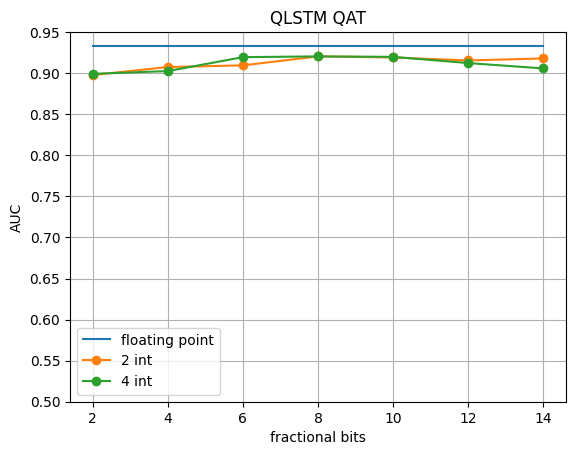

In [11]:
# lstm_float = [0.9207847688802558,0.9207847688802558,0.9207847688802558,0.9207847688802558,0.9207847688802558,0.9207847688802558,0.9207847688802558]
lstm_float = [0.9331680336005777,0.9331680336005777,0.9331680336005777,0.9331680336005777,0.9331680336005777,0.9331680336005777,0.9331680336005777]
plt.plot([2,4,6,8,10,12,14], lstm_float, "-", label = "floating point")
plt.plot([2,4,6,8,10,12,14], LSTM_2int, "-o", label = '2 int')
plt.plot([2,4,6,8,10,12,14], LSTM_4int, "-o", label = '4 int')

plt.legend()
plt.xlabel("fractional bits")
plt.ylabel("AUC")
plt.title("QLSTM QAT")
plt.grid()
plt.ylim([0.5, 0.95]) 

## QLSTM weight

In [2]:
qlstm = load_model('qlstm_2int_test3/model_qlstm_2frac.h5', custom_objects={'QLSTM': QLSTM, 'QDense': QDense, 'quantized_bits': quantized_bits, 'QActivation': QActivation})
# model_save_quantized_weights(qlstm, f"qat2int2fra_weight")

[0.5, 0.8385769516318569, 0.9071477595079078, 0.9178439032986867, 0.9178388081238352, 0.9182998711996075, 0.9200245175391999, 0.9187668987453488, 0.9216360349176452, 0.9214260323115689]


(0.5, 1.05)

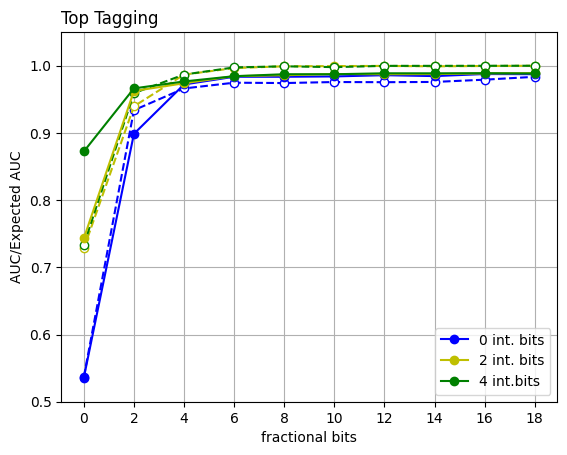

In [38]:
LSTM_float = 0.9331680336005777
GRU_float = 0.9312736230093996

GRU_0int = np.array(new_GRU_0int)/GRU_float

GRU_2int = np.array(new_GRU_2int)/GRU_float

GRU_4int = np.array(new_GRU_4int)/GRU_float


LSTM_0int = np.array(new_LSTM_0int)/LSTM_float

print(new_LSTM_0int)
LSTM_2int = np.array(new_LSTM_2int)/LSTM_float

LSTM_4int = np.array(new_LSTM_4int)/LSTM_float

x = [0,2,4,6,8,10,12,14,16,18]
default_x_ticks = range(len(x))
plt.xticks(default_x_ticks, x)
plt.plot(default_x_ticks, GRU_0int, "bo--", markerfacecolor = 'white')
plt.plot(default_x_ticks, GRU_2int, "yo--", markerfacecolor = 'white')
plt.plot(default_x_ticks, GRU_4int, "go--", markerfacecolor = 'white')
plt.plot(default_x_ticks, LSTM_0int, "bo-", label = '0 int. bits')
plt.plot(default_x_ticks, LSTM_2int, "yo-", label = '2 int. bits')
plt.plot(default_x_ticks, LSTM_4int, "go-", label = '4 int.bits')

plt.legend()
plt.xlabel("fractional bits")
plt.ylabel("AUC/Expected AUC")
plt.title("Top Tagging", loc='left')
plt.grid()
plt.ylim([0.5, 1.05]) 

range(0, 6)

## Post Training Quantization

## QGRU

In [13]:
gru = load_model('gru/model_toptag_gru.h5')

In [18]:
#GRU_2intptq = []
#GRU_4intptq = []
for j in [14]:
    for i in [14]:
        int_bits = j
        total_bits = i + int_bits + 1
        config = {
            "QGRU":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits}, {int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QDense":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
            "relu_1" : f"quantized_relu({total_bits},{int_bits},1)",
        }
    
        qmodel = model_quantize(gru, config, total_bits, transfer_weights=True)
        
        #labels = ['j_t']
        y_keras = qmodel.predict(x_test)
        auc_score = roc_auc_score(y_test, y_keras)
        print(auc_score)
#         if j == 2:
#             GRU_2intptq.append(auc_score)
#         else:
#             GRU_4intptq.append(auc_score)

624/624 [==============================] - 38s 59ms/step
0.830363328778428


In [29]:
print(GRU_2intptq)

[0.4522579151782626, 0.6300847031112966, 0.8411201724826229, 0.835669812690921, 0.841164596980513, 0.8412067703557862, 0.8340651391272165]


In [ ]:
GRU_2intptq = [0.4522579151782626, 0.6300847031112966, 0.8411201724826229, 0.835669812690921, 0.841164596980513, 0.8412067703557862, 0.8340651391272165]

In [30]:
print(GRU_4intptq)

[0.4430225992209428, 0.6373102389056136, 0.833872698292447, 0.8388645074220116, 0.8325862671390327, 0.8322966310703882, 0.8025046010333377]


In [ ]:
GRU_4intptq = [0.4430225992209428, 0.6373102389056136, 0.833872698292447, 0.8388645074220116, 0.8325862671390327, 0.8322966310703882, 0.8025046010333377]

(0.4, 0.95)

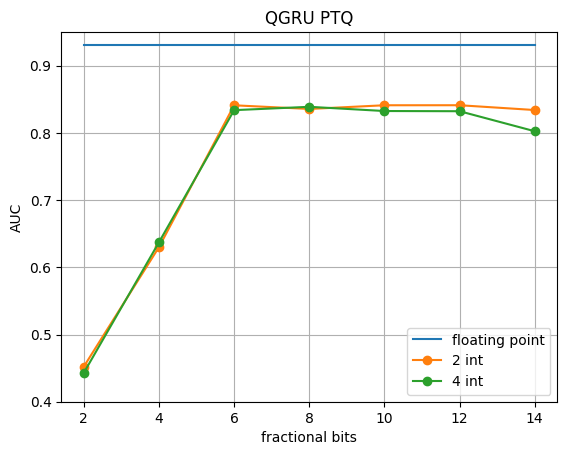

In [21]:
float_gru = [0.9307736230093996, 0.9307736230093996, 0.9307736230093996, 0.9307736230093996, 0.9307736230093996, 0.9307736230093996, 0.9307736230093996]
plt.plot([2,4,6,8,10,12,14], float_gru, "-", label = "floating point")
plt.plot([2,4,6,8,10,12,14], GRU_2intptq, "-o", label = '2 int')
plt.plot([2,4,6,8,10,12,14], GRU_4intptq, "-o", label = '4 int')

plt.legend()
plt.xlabel("fractional bits")
plt.ylabel("AUC")
plt.title("QGRU PTQ")
plt.grid()
plt.ylim([0.4, 0.95]) 

## QLSTM

In [24]:
lstm = load_model('lstm/model_lstm.h5')

In [31]:
#LSTM_2intptq = []
#LSTM_4intptq = []
for j in [14]:
    for i in [14]:
        int_bits = j
        total_bits = i + int_bits + 1
        config = {
            "QLSTM":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits}, {int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QDense":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
            "relu_1" : f"quantized_relu({total_bits},{int_bits},1)",
        }
    
        qmodel = model_quantize(lstm, config, total_bits, transfer_weights=True)
        
        labels = ['j_t']
        y_keras = qmodel.predict(x_test)
        auc_score = roc_auc_score(y_test, y_keras)
        print(auc_score)
#         if j == 2:
#             LSTM_2intptq.append(auc_score)
#         else:
#             LSTM_4intptq.append(auc_score)

624/624 [==============================] - 39s 60ms/step
0.890858460384081


In [27]:
print(LSTM_2intptq)

[0.5463666639773792, 0.841102540363734, 0.8768162991889888, 0.8862577586850421, 0.88434733443164, 0.8838215314813267, 0.8891859516522377]


In [79]:
LSTM_2intptq = [0.5463666639773792, 0.841102540363734, 0.8768162991889888, 0.8862577586850421, 0.88434733443164, 0.8838215314813267, 0.8891859516522377]

In [28]:
print(LSTM_4intptq)

[0.6673664542611882, 0.8206308915848494, 0.8785826164211273, 0.8852858063462926, 0.8889393482043297, 0.8921200739156111, 0.89170024959724]


In [80]:
LSTM_4intptq = [0.6673664542611882, 0.8206308915848494, 0.8785826164211273, 0.8852858063462926, 0.8889393482043297, 0.8921200739156111, 0.89170024959724]

(0.5, 0.95)

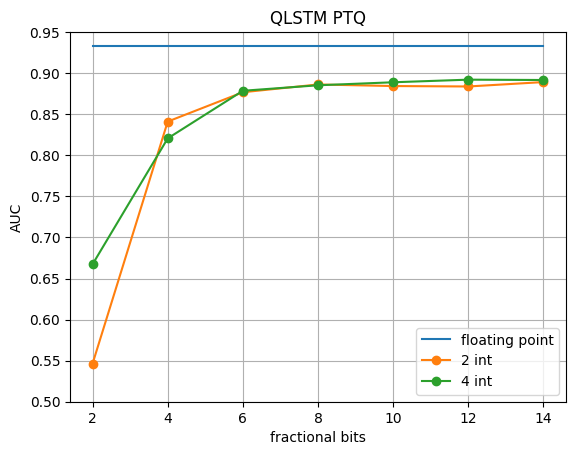

In [26]:
lstm_float = [0.9331680336005777,0.9331680336005777,0.9331680336005777,0.9331680336005777,0.9331680336005777,0.9331680336005777,0.9331680336005777]
plt.plot([2,4,6,8,10,12,14], lstm_float, "-", label = "floating point")
plt.plot([2,4,6,8,10,12,14], LSTM_2intptq, "-o", label = '2 int')
plt.plot([2,4,6,8,10,12,14], LSTM_4intptq, "-o", label = '4 int')

plt.legend()
plt.xlabel("fractional bits")
plt.ylabel("AUC")
plt.title("QLSTM PTQ")
plt.grid()
plt.ylim([0.5, 0.95]) 